In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, CustomFilter, CustomFactor
from quantopian.pipeline.data import Fundamentals 
from quantopian.pipeline.data import factset
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.classifiers.morningstar import Sector 
from quantopian.pipeline.filters import QTradableStocksUS, Q1500US, Q500US
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as st
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Latest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from zipline.utils.numpy_utils import ( repeat_first_axis, repeat_last_axis )

In [2]:
from quantopian.pipeline.factors import ( CustomFactor, BusinessDaysSincePreviousEvent, 
                                         BusinessDaysUntilNextEvent, SimpleMovingAverage, 
                                         AverageDollarVolume, Returns, RSI, 
                                         RollingLinearRegressionOfReturns, RollingSpearmanOfReturns, 
                                         AnnualizedVolatility, Returns, DailyReturns, EWMA)

In [3]:
import talib
import pandas as pd
import numpy as np
from time import time

In [4]:
import alphalens as al
import pyfolio as pf
from scipy import stats
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [5]:
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from sklearn.metrics import classification_report
from quantopian.interactive.data.quandl import fred_dgs10

In [6]:
WIN_LIMIT = 0.0

In [7]:
def preprocess(a):
    
    a = np.nan_to_num(a - np.nanmean(a))
    
    a = winsorize(a, limits=[WIN_LIMIT,WIN_LIMIT])

    return preprocessing.scale(a)

In [8]:
def normalize(x):
    
    r = x - x.mean()
    denom = r.abs().sum()
    
    return r/denom

In [9]:
def z_score(x):
    
    z = (x - x.mean()) / x.std()
    
    return z 

In [10]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [11]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios
es = EarningsSurprises

In [12]:
has_data = (factset.Fundamentals.capex_assets_qf.latest.notnull()
            & factset.Fundamentals.zscore_qf.latest.notnull()
            & factset.Fundamentals.assets.latest.notnull()
            & is_.total_revenue.latest.notnull()
            & Fundamentals.long_term_debt.latest.notnull()
            & Fundamentals.current_debt.latest.notnull()
            & Fundamentals.cash_and_cash_equivalents.latest.notnull()
            & Fundamentals.growth_score.latest.notnull()
)

In [13]:
is_tradeable = (QTradableStocksUS()
                & has_data )

In [14]:
universe = is_tradeable

In [16]:
def make_factors():
    
    class efficiency_ratio(CustomFactor):    
        inputs = [USEquityPricing.close, USEquityPricing.high, USEquityPricing.low]   
        window_length = 126
     
        def compute(self, today, assets, out, close, high, low):
            lb = self.window_length
            e_r = np.zeros(len(assets), dtype=np.float64)
            a=np.array([high[1:(lb):1]-low[1:(lb):1],
                     abs(high[1:(lb):1]-close[0:(lb-1):1]),
                     abs(low[1:(lb):1]-close[0:(lb-1):1])])      
            b=a.T.max(axis=1)
            c=b.sum(axis=1)
            e_r=abs(close[-1]-close[0]) / c  
            out[:] = preprocess(e_r)        
    
    class AverageRangeRatio(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.open, USEquityPricing.high, USEquityPricing.low]
        window_length = 63
        def compute(self, today, assets, out, close, open, high, low):
            spread = high - low
            avg_spread = np.nanmean(spread, axis=0)
            daily_move = close - open
            abs_daily_move = np.absolute(daily_move)
            avg_abs_daily_move = np.nanmean(abs_daily_move, axis=0)
            out[:] = preprocess(avg_abs_daily_move / avg_spread)
    
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = preprocess(np.nanstd(rets, axis=0))
                
    class fcf(CustomFactor):
        inputs = [Fundamentals.fcf_yield]
        window_length = 1
        def compute(self, today, assets, out, fcf_yield):
            out[:] = preprocess(np.nan_to_num(fcf_yield[-1,:]))
                
    class Direction(CustomFactor):
        inputs = [USEquityPricing.open, USEquityPricing.close]
        window_length = 21
        def compute(self, today, assets, out, open, close):
            p = (close-open)/close
            out[:] = preprocess(np.nansum(-p,axis=0))
                
    class mean_rev(CustomFactor):   
        inputs = [USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
        window_length = 30
        def compute(self, today, assets, out, high, low, close):
            
            p = (high+low+close)/3
 
            m = len(close[0,:])
            n = len(close[:,0])
                
            b = np.zeros(m)
            a = np.zeros(m)
                
            for k in range(10,n+1):
                price_rel = np.nanmean(p[-k:,:],axis=0)/p[-1,:]
                wt = np.nansum(price_rel)
                b += wt*price_rel
                price_rel = 1.0/price_rel
                wt = np.nansum(price_rel)
                a += wt*price_rel
                
            out[:] = preprocess(b-a)
                
    class growthscore(CustomFactor):
        inputs = [Fundamentals.growth_score]
        window_length = 1
        def compute(self, today, assets, out, growth_score):
            out[:] = preprocess(growth_score[-1,:])
                
    class peg_ratio(CustomFactor):
        inputs = [Fundamentals.peg_ratio]
        window_length = 1
        def compute(self, today, assets, out, peg_ratio):
            out[:] = preprocess(-1.0/peg_ratio[-1,:])
                
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252
            
        _x = np.arange(window_length)
        _x_var = np.var(_x)
 
        def compute(self, today, assets, out, close):
            
            x_matrix = repeat_last_axis(
            (self.window_length - 1) / 2 - self._x,
            len(assets),
            )
 
            y_bar = np.nanmean(close, axis=0)
            y_bars = repeat_first_axis(y_bar, self.window_length)
            y_matrix = close - y_bars
 
            out[:] = preprocess(-np.divide(
            (x_matrix * y_matrix).sum(axis=0) / self._x_var,
            self.window_length
            ))
                
    class SalesGrowth(CustomFactor):
        inputs = [factset.Fundamentals.sales_gr_qf]
        window_length = 2*252
        def compute(self, today, assets, out, sales_growth):
            sales_growth = np.nan_to_num(sales_growth)
            sales_growth = preprocessing.scale(sales_growth,axis=0)
            out[:] = preprocess(sales_growth[-1])
 
    class Gross_Income_Margin(CustomFactor):
        inputs = [Fundamentals.cost_of_revenue, Fundamentals.total_revenue]
        window_length = 1
        def compute(self, today, assets, out, cost_of_revenue, sales):
            gross_income_margin = sales[-1]/sales[-1] - cost_of_revenue[-1]/sales[-1]
            out[:] = preprocess(-gross_income_margin)
 
    class MaxGap(CustomFactor): 
        # the biggest absolute overnight gap in the previous 90 sessions
        inputs = [USEquityPricing.close] ; window_length = 90
        def compute(self, today, assets, out, close):
            abs_log_rets = np.abs(np.diff(np.log(close),axis=0))
            max_gap = np.max(abs_log_rets, axis=0)
            out[:] = preprocess(max_gap)
                
    class fcf_ev(CustomFactor):
        inputs=[
            Fundamentals.fcf_per_share,
            Fundamentals.shares_outstanding,
            Fundamentals.enterprise_value,]
        window_length = 1
        def compute(self, today, assets, out, fcf, shares, ev):
            v = fcf*shares/ev
            v[np.isinf(v)] = np.nan
                 
            out[:] = preprocess(v[-1])
                
    class DebtToTotalAssets(CustomFactor):
        inputs = [Fundamentals.long_term_debt,
            Fundamentals.current_debt,
            Fundamentals.cash_and_cash_equivalents,
            Fundamentals.total_assets]
        window_length = 1
            
        def compute(self, today, assets, out, ltd, std, cce, ta):
            std_part = np.maximum(std - cce, np.zeros(std.shape))
            v = np.divide(ltd + std_part, ta)
            v[np.isinf(v)] = np.nan
            out[:] = preprocess(np.ravel(v))
                
    class Piotroski(CustomFactor):
        inputs = [
                Fundamentals.roa,
                Fundamentals.operating_cash_flow,
                Fundamentals.cash_flow_from_continuing_operating_activities,
                Fundamentals.long_term_debt_equity_ratio,
                Fundamentals.current_ratio,
                Fundamentals.shares_outstanding,
                Fundamentals.gross_margin,
                Fundamentals.assets_turnover,
                ]
 
        window_length = 100
    
        def compute(self, today, assets, out,roa, cash_flow, cash_flow_from_ops, long_term_debt_ratio, current_ratio, shares_outstanding, gross_margin, assets_turnover):
            
            profit = (
                        (roa[-1] > 0).astype(int) +
                        (cash_flow[-1] > 0).astype(int) +
                        (roa[-1] > roa[0]).astype(int) +
                        (cash_flow_from_ops[-1] > roa[-1]).astype(int)
                    )
        
            leverage = (
                        (long_term_debt_ratio[-1] < long_term_debt_ratio[0]).astype(int) +
                        (current_ratio[-1] > current_ratio[0]).astype(int) + 
                        (shares_outstanding[-1] <= shares_outstanding[0]).astype(int)
                        )
        
            operating = (
                        (gross_margin[-1] > gross_margin[0]).astype(int) +
                        (assets_turnover[-1] > assets_turnover[0]).astype(int)
                        )
        
            out[:] = preprocess(profit + leverage + operating)
                
    class Quick_Ratio(CustomFactor):
        inputs=[factset.Fundamentals.quick_ratio_qf]
        window_length = 1
        def compute(self, today, assets, out, quick_ratio_qf):
            out[:] = preprocess(quick_ratio_qf[-1])
                
    class AdvancedMomentum(CustomFactor):
        inputs = (USEquityPricing.close, Returns(window_length=126))
        window_length = 252
 
        def compute(self, today, assets, out, prices, returns):
            am = np.divide(
            (
            (prices[-21] - prices[-252]) / prices[-252] -
            prices[-1] - prices[-21]
            ) / prices[-21],
            np.nanstd(returns, axis=0)
            )
                
            out[:] = preprocess(-am)

    class STA(CustomFactor):  
        inputs = [Fundamentals.operating_cash_flow,  
                  Fundamentals.net_income_continuous_operations,  
                  Fundamentals.total_assets]  
        window_length = 1  
        def compute(self, today, assets, out, ocf, ni, ta):  
            ta = np.where(np.isnan(ta), 0, ta)  
            ocf = np.where(np.isnan(ocf), 0, ocf)  
            ni = np.where(np.isnan(ni), 0, ni)  
            out[:] = preprocess(abs(ni[-1] - ocf[-1])/ ta[-1])
            
    class SNOA(CustomFactor):  
        inputs = [Fundamentals.total_assets,  
                 Fundamentals.cash_and_cash_equivalents,  
                 Fundamentals.current_debt, # same as short-term debt?  
                 Fundamentals.minority_interest_balance_sheet,  
                 Fundamentals.long_term_debt, # check same?  
                 Fundamentals.preferred_stock] # check same?  
        window_length = 1  
        def compute(self, today, assets, out, ta, cace, cd, mi, ltd, ps):  
            ta = np.where(np.isnan(ta), 0, ta)  
            cace = np.where(np.isnan(cace), 0, cace)  
            cd = np.where(np.isnan(cd), 0, cd)  
            mi = np.where(np.isnan(mi), 0, mi)  
            ltd = np.where(np.isnan(ltd), 0, ltd)  
            ps = np.where(np.isnan(ps), 0, ps)  
            results = ((ta[-1]-cace[-1])-(ta[-1]-cace[-1]-ltd[-1]-cd[-1]-ps[-1]-mi[-1]))/ta[-1]  
            out[:] = preprocess(np.where(np.isnan(results),0,results))
            
    class ROA(CustomFactor):  
        inputs = [Fundamentals.roa]  
        window_length = 1  
        def compute(self, today, assets, out, roa):  
            out[:] = preprocess(np.where(roa[-1]>0,1,0))
            
    class ROA_GROWTH(CustomFactor):  
        inputs = [Fundamentals.roa]  
        window_length = 252  
        def compute(self, today, assets, out, roa):  
            out[:] = np.where(roa[-1]>roa[-252],1,0)
            
    class FCFTA_ROA(CustomFactor):  
        inputs = [Fundamentals.free_cash_flow,  
                  Fundamentals.total_assets,  
                  Fundamentals.roa]  
        window_length = 1  
        def compute(self, today, assets, out, fcf, ta, roa):  
            out[:] = preprocess(np.where(fcf[-1]/ta[-1]>roa[-1],1,0))
            
    class FCFTA_GROWTH(CustomFactor):  
        inputs = [Fundamentals.free_cash_flow,  
                  Fundamentals.total_assets]  
        window_length = 252  
        def compute(self, today, assets, out, fcf, ta):  
            out[:] = preprocess(np.where(fcf[-1]/ta[-1]>fcf[-252]/ta[-252],1,0))
            
    class LTD_GROWTH(CustomFactor):  
        inputs = [Fundamentals.total_assets,  
                  Fundamentals.long_term_debt]  
        window_length = 252  
        def compute(self, today, assets, out, ta, ltd):  
            out[:] = preprocess(np.where(ltd[-1]/ta[-1]<ltd[-252]/ta[-252],1,0))
            
    class CR_GROWTH(CustomFactor):  
        inputs = [Fundamentals.current_ratio]  
        window_length = 252  
        def compute(self, today, assets, out, cr):  
            out[:] = preprocess(np.where(cr[-1]>cr[-252],1,0))
            
    class GM_GROWTH(CustomFactor):  
        inputs = [Fundamentals.gross_margin]  
        window_length = 252  
        def compute(self, today, assets, out, gm):  
            out[:] = preprocess(np.where(gm[-1]>gm[-252],1,0))
            
    class Value(CustomFactor):
        # value factor based on OCF/EV    
        inputs = [cfs.operating_cash_flow, v.enterprise_value] 
        window_length = 1
  
        def compute(self, today, assets, out, ocf, ev):
            factor_df = pd.DataFrame(index=assets)
            factor_df["ocf"] = ocf[-1]
            factor_df["ev"] = ev[-1]
            out[:] = preprocess((factor_df['ocf'] / factor_df['ev']))
            
    class GP_to_A(CustomFactor):
        inputs = [is_.gross_profit, bs.total_assets]
        window_length = 1
        def compute(self, today, assets, out, gross_profit, total_assets):       
            out[:] = preprocess(gross_profit[-1] / total_assets[-1])
            
    class ItoA(CustomFactor):
        inputs = [factset.Fundamentals.ppe_gross,
              factset.Fundamentals.inven,
              factset.Fundamentals.assets]
        window_length = 270

        def compute(self, today, assets, out, ppe, inv, ta):
            ppe = np.nan_to_num(ppe)
            inv = np.nan_to_num(inv)
            out[:] = preprocess(-(ppe[-1]-ppe[0]+inv[-1]-inv[0])/ta[0])
            
    return {
            'Vol_3M':                  Vol_3M,
            'ItoA':                    ItoA,
            'GP_to_A':                 GP_to_A,
            'Value':                   Value,
            'AverageRangeRatio':       AverageRangeRatio,
            'efficiency_ratio':        efficiency_ratio,
            'FCF':                     fcf,
            'Direction':               Direction,
            'mean_rev':                mean_rev,
            'GrowthScore':             growthscore,
            'PegRatio':                peg_ratio,
            'Trendline':               Trendline,
            'SalesGrowth':             SalesGrowth,
            'Gross_Income_Margin':     Gross_Income_Margin,
            'MaxGap':                  MaxGap,
            'fcf_ev':                  fcf_ev,
            'DebtToTotalAssets':       DebtToTotalAssets,
            'Piotroski':               Piotroski,
            'Quick_Ratio':             Quick_Ratio,
            'AdvancedMomentum':        AdvancedMomentum,
            'STA':                     STA,  
            'SNOA':                    SNOA,  
            'ROA':                     ROA,  
            'ROA_GROWTH':              ROA_GROWTH,  
            'FCFTA_ROA':               FCFTA_ROA,  
            'FCFTA_GROWTH':            FCFTA_GROWTH,  
            'LTD_GROWTH':              LTD_GROWTH,  
            'CR_GROWTH':               CR_GROWTH,  
            'GM_GROWTH':               GM_GROWTH,  
        }

In [17]:
factors = make_factors()

In [18]:
combined_alpha = None

for name, f in factors.iteritems():
        if combined_alpha == None:
            combined_alpha = f(mask=universe)
        else:
            combined_alpha = combined_alpha+f(mask=universe)

In [19]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe):
    
    factors_pipe = OrderedDict()
    
    factors_pipe['5D_Returns'] = Returns(inputs = [USEquityPricing.close],
                                      mask = universe, window_length = 5)
        
    factors_pipe['combined_alpha'] = combined_alpha

    factors_pipe['Sector'] = Sector()
    
    for name, f in factors.iteritems():
        factors_pipe[name] = f(mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [20]:
ml_pipe = make_ml_pipeline(factors, universe)

In [21]:
start_timer = time()
start = pd.Timestamp("2010-03-01") 
end = pd.Timestamp("2014-03-01")

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [22]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 168.62 secs


In [23]:
asset_list = results.index.levels[1]
num_stocks = len(asset_list)
print 'Number of stocks:', num_stocks 
results.head()

Number of stocks: 1729


5D_Returns  AdvancedMomentum  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    -0.016987         -0.817281   
                          Equity(24 [AAPL])    0.020954         -0.246546   
                          Equity(31 [ABAX])   -0.021965          0.129444   
                          Equity(41 [ARCB])    0.035108         -0.236623   
                          Equity(52 [ABM])    -0.013976          0.075982   

                                             AverageRangeRatio  CR_GROWTH  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            2.323599   0.688095   
                          Equity(24 [AAPL])           1.858628   0.688095   
                          Equity(31 [ABAX])          -0.253399  -1.453288   
                          Equity(41 [ARCB])          -0.826737  -1.453288   
                          Equity(52 [ABM])            0.174477  -1.453288   

                                             DebtToTotalAssets  Direction  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            0.065062   1.102901   
                          Equity(24 [AAPL])          -0.993202   0.198163   
                          Equity(31 [ABAX])          -1.017420   0.272144   
                          Equity(41 [ARCB])          -0.949232  -0.684024   
                          Equity(52 [ABM])           -0.492917  -0.270927   

                                                  FCF  FCFTA_GROWTH  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])  -0.421663      0.857868   
                          Equity(24 [AAPL]) -0.012076      0.857868   
                          Equity(31 [ABAX]) -0.166194      0.857868   
                          Equity(41 [ARCB]) -0.642651     -1.165681   
                          Equity(52 [ABM])   0.104426      0.857868   

                                             FCFTA_ROA  GM_GROWTH    ...     \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    0.778133   0.788605    ...      
                          Equity(24 [AAPL])   0.778133   0.788605    ...      
                          Equity(31 [ABAX])   0.778133   0.788605    ...      
                          Equity(41 [ARCB])   0.778133  -1.268062    ...      
                          Equity(52 [ABM])    0.778133  -1.268062    ...      

                                                  STA  SalesGrowth  Sector  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])   0.152123     1.321375     101   
                          Equity(24 [AAPL])  0.366004     1.572358     311   
                          Equity(31 [ABAX]) -0.322210     0.549050     206   
                          Equity(41 [ARCB])  1.440485     0.205066     310   
                          Equity(52 [ABM])   0.063139    -0.683522     310   

                                             Trendline     Value    Vol_3M  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])   -0.267584  0.454202  1.507994   
                          Equity(24 [AAPL])   5.937829  0.174643 -0.268974   
                          Equity(31 [ABAX])  -0.146954 -0.257982  0.386952   
                          Equity(41 [ARCB])  -0.407016 -0.875558  1.688185   
                          Equity(52 [ABM])   -0.428672  0.488575 -0.099469   

                                             combined_alpha  efficiency_ratio  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])         2.277996         -0.893107   
                          Equity(24 [AAPL])       16.349928          0.806395   
                          Equity(31 [ABAX])        1.840453         -0.668185   
                          Equity(41 [ARCB])      -20.532475         -0.316913   
                          Equity(52 [ABM])        -0.441426         -0.659513   

                                               fcf_ev  mean_rev  
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])  -0.669354  0.534420  
                          Equity(24 [AAPL])  0.125801 -0.114256  
                          Equity(31 [ABAX]) -0.222379 -0.307112  
                          Equity(41 [ARCB]) -1.280883 -1.545142  

In [25]:
results_s = results.drop('Sector', axis=1)

In [26]:
results_s = results_s.drop('5D_Returns', axis=1)

In [27]:
results_s.index = results_s.index.droplevel(1)
results_s.dropna()
results_s.head()

AdvancedMomentum  AverageRangeRatio  CR_GROWTH  \
2010-03-01 00:00:00+00:00         -0.817281           2.323599   0.688095   
2010-03-01 00:00:00+00:00         -0.246546           1.858628   0.688095   
2010-03-01 00:00:00+00:00          0.129444          -0.253399  -1.453288   
2010-03-01 00:00:00+00:00         -0.236623          -0.826737  -1.453288   
2010-03-01 00:00:00+00:00          0.075982           0.174477  -1.453288   

                           DebtToTotalAssets  Direction       FCF  \
2010-03-01 00:00:00+00:00           0.065062   1.102901 -0.421663   
2010-03-01 00:00:00+00:00          -0.993202   0.198163 -0.012076   
2010-03-01 00:00:00+00:00          -1.017420   0.272144 -0.166194   
2010-03-01 00:00:00+00:00          -0.949232  -0.684024 -0.642651   
2010-03-01 00:00:00+00:00          -0.492917  -0.270927  0.104426   

                           FCFTA_GROWTH  FCFTA_ROA  GM_GROWTH    GP_to_A  \
2010-03-01 00:00:00+00:00      0.857868   0.778133   0.788605  -0.929934   
2010-03-01 00:00:00+00:00      0.857868   0.778133   0.788605   0.407558   
2010-03-01 00:00:00+00:00      0.857868   0.778133   0.788605   0.350851   
2010-03-01 00:00:00+00:00     -1.165681   0.778133  -1.268062 -11.308187   
2010-03-01 00:00:00+00:00      0.857868   0.778133  -1.268062  -0.358918   

                             ...         SNOA       STA  SalesGrowth  \
2010-03-01 00:00:00+00:00    ...     0.380467  0.152123     1.321375   
2010-03-01 00:00:00+00:00    ...    -1.031279  0.366004     1.572358   
2010-03-01 00:00:00+00:00    ...    -1.024966 -0.322210     0.549050   
2010-03-01 00:00:00+00:00    ...    -0.887497  1.440485     0.205066   
2010-03-01 00:00:00+00:00    ...    -0.585094  0.063139    -0.683522   

                           Trendline     Value    Vol_3M  combined_alpha  \
2010-03-01 00:00:00+00:00  -0.267584  0.454202  1.507994        2.277996   
2010-03-01 00:00:00+00:00   5.937829  0.174643 -0.268974       16.349928   
2010-03-01 00:00:00+00:00  -0.146954 -0.257982  0.386952        1.840453   
2010-03-01 00:00:00+00:00  -0.407016 -0.875558  1.688185      -20.532475   
2010-03-01 00:00:00+00:00  -0.428672  0.488575 -0.099469       -0.441426   

                           efficiency_ratio    fcf_ev  mean_rev  
2010-03-01 00:00:00+00:00         -0.893107 -0.669354  0.534420  
2010-03-01 00:00:00+00:00          0.806395  0.125801 -0.114256  
2010-03-01 00:00:00+00:00         -0.668185 -0.222379 -0.307112  
2010-03-01 00:00:00+00:00         -0.316913 -1.280883 -1.545142  
2010-03-01 00:00:00+00:00         -0.659513  0.157802 -0.302183  

[5 rows x 30 columns]

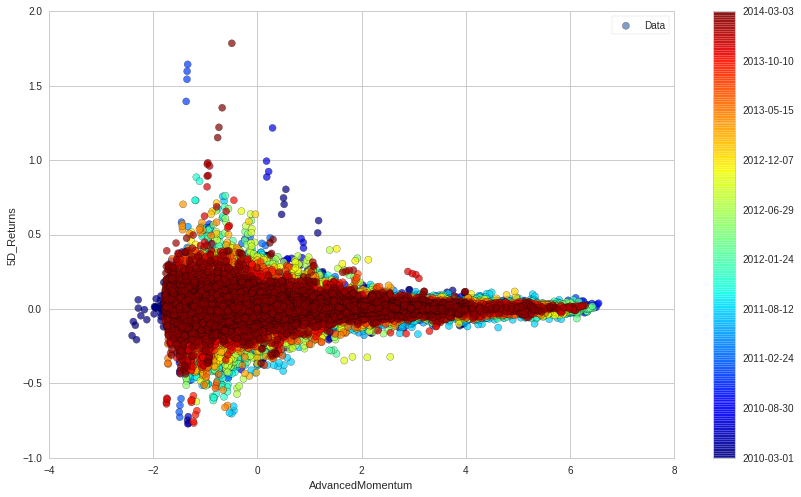

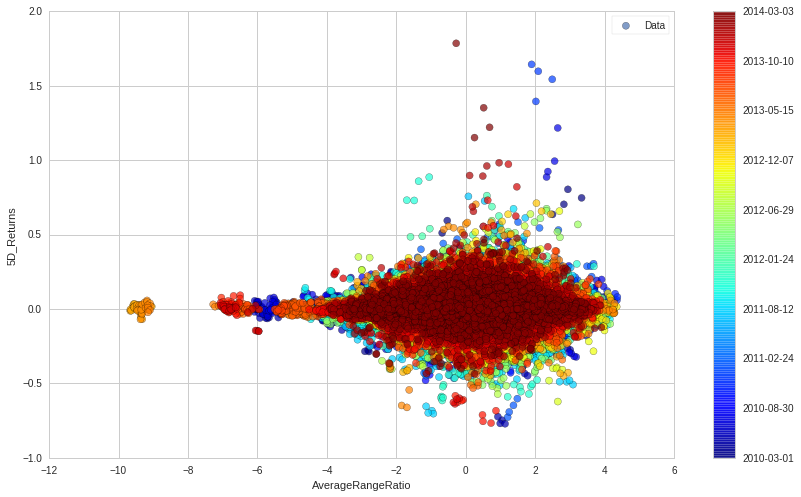

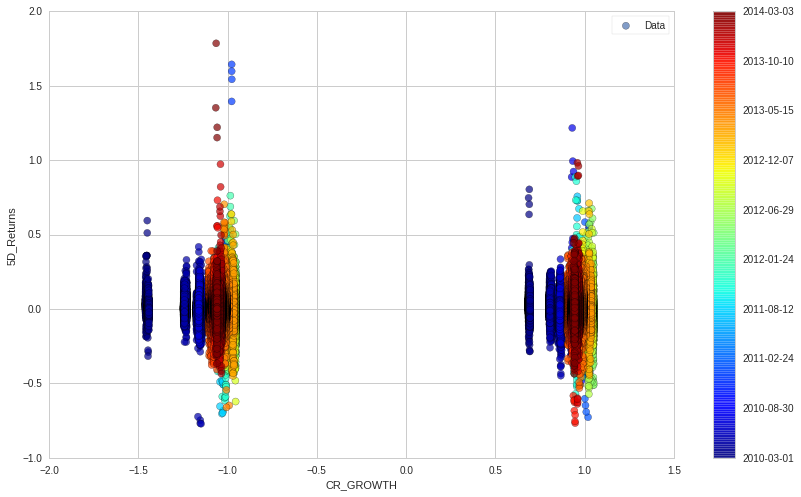

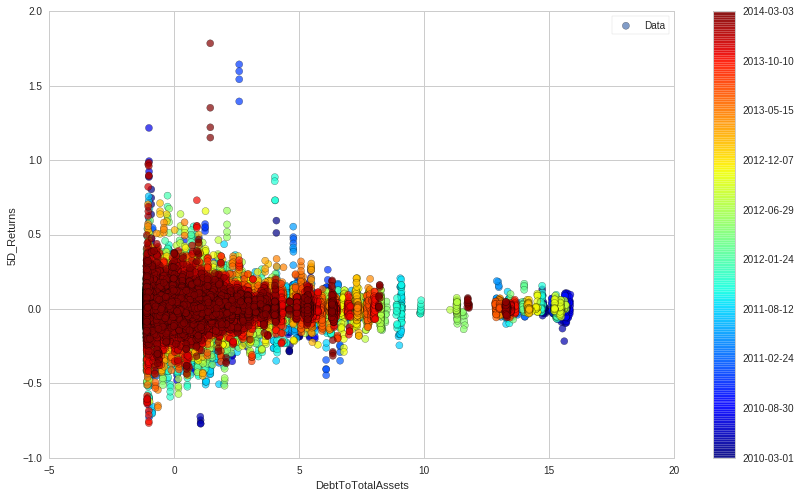

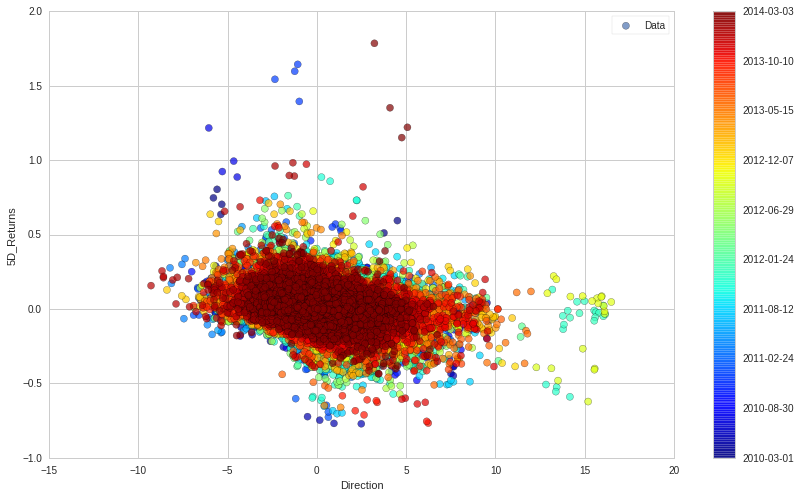

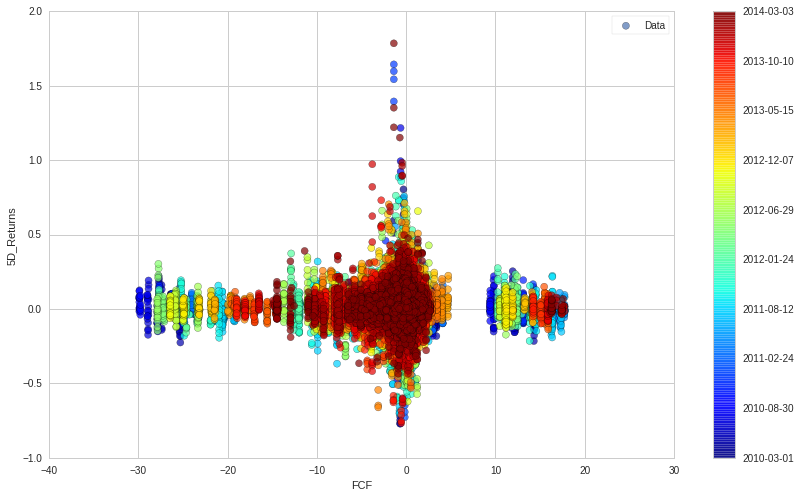

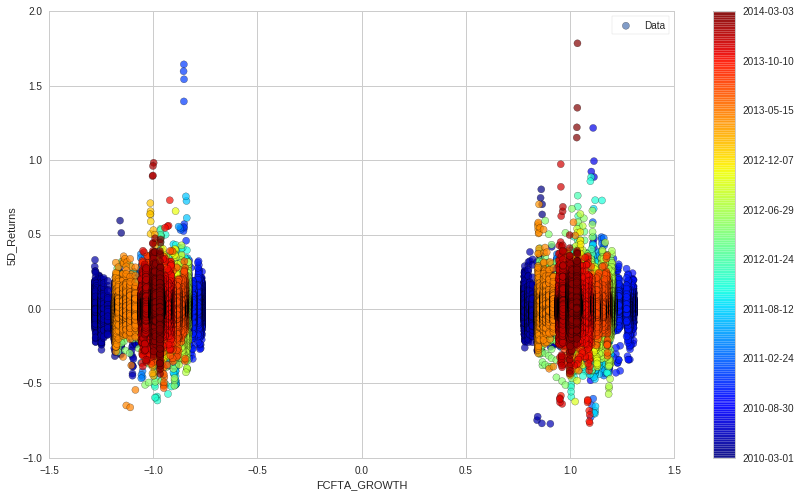

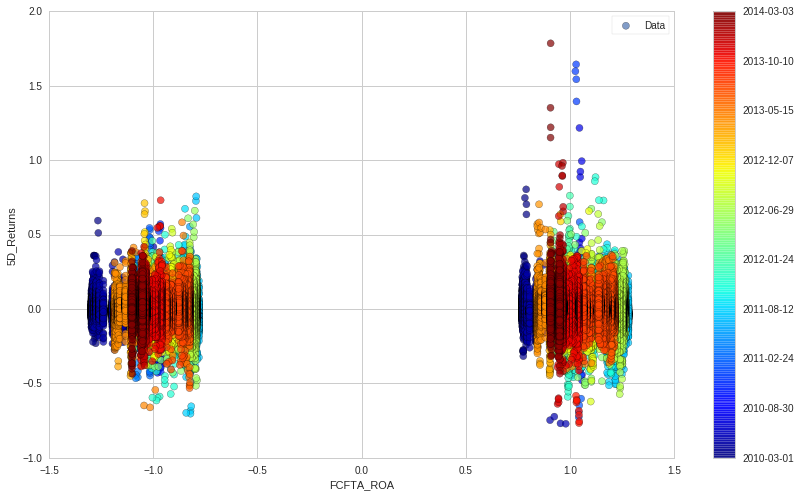

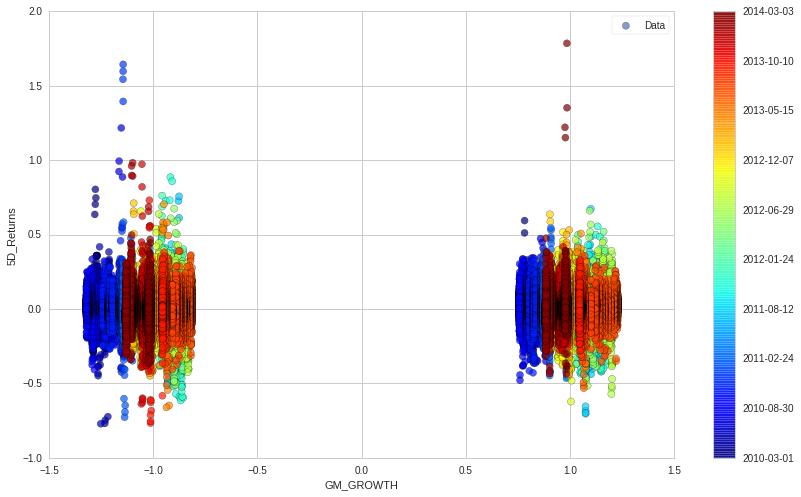

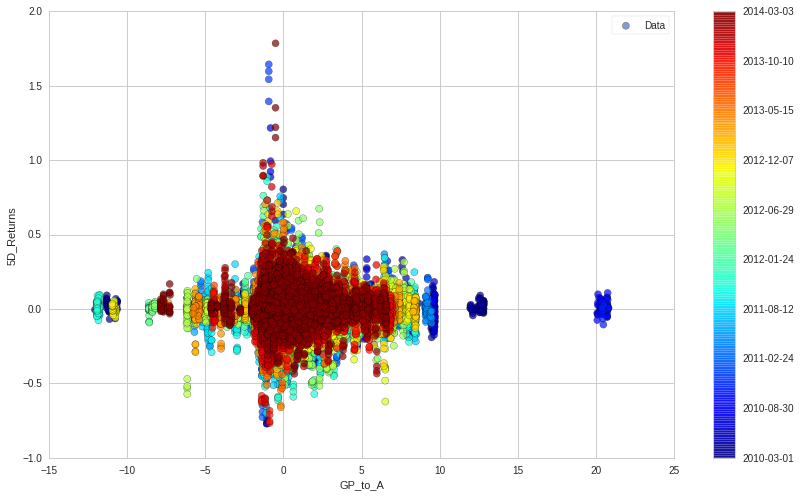

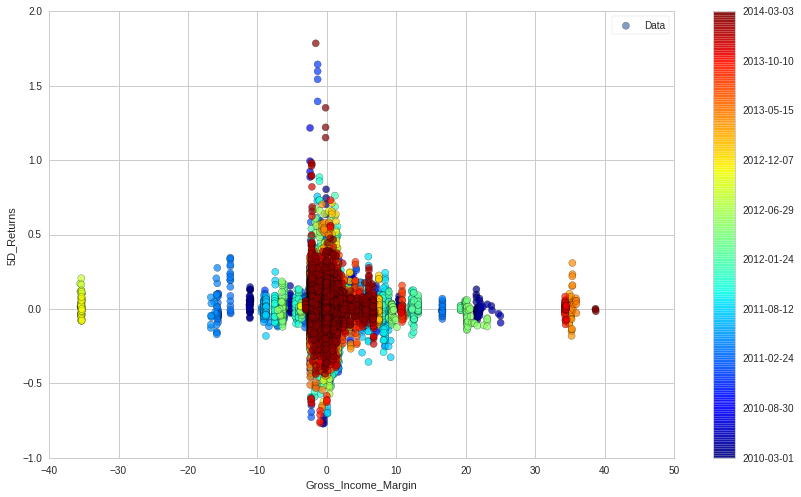

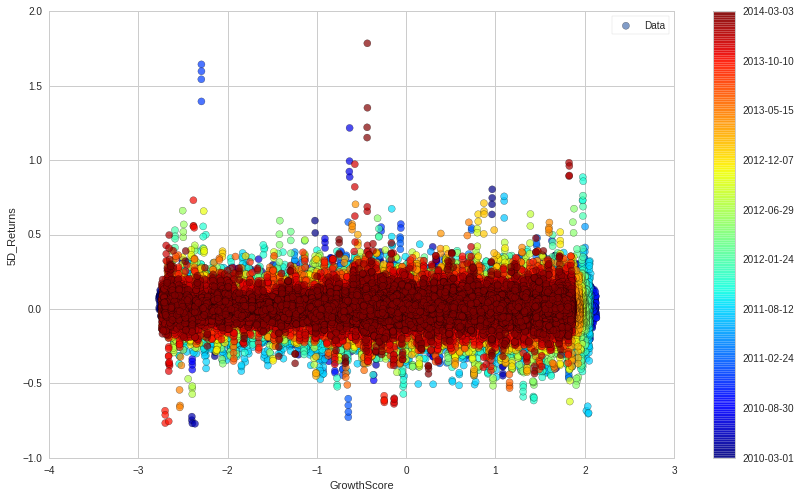

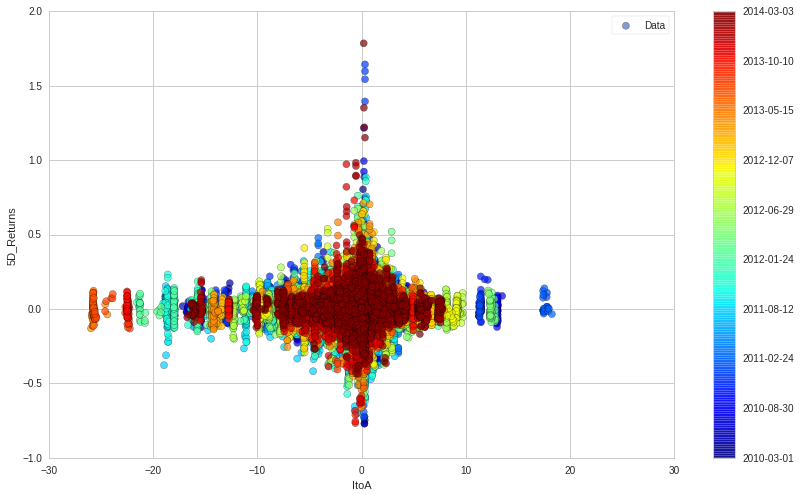

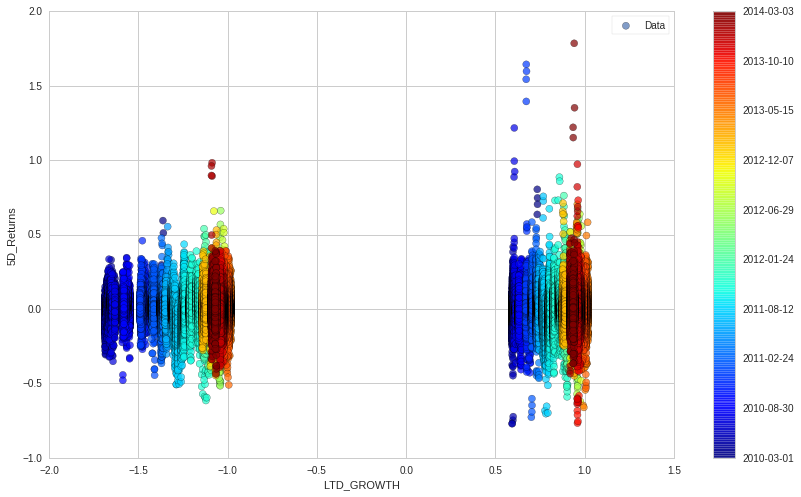

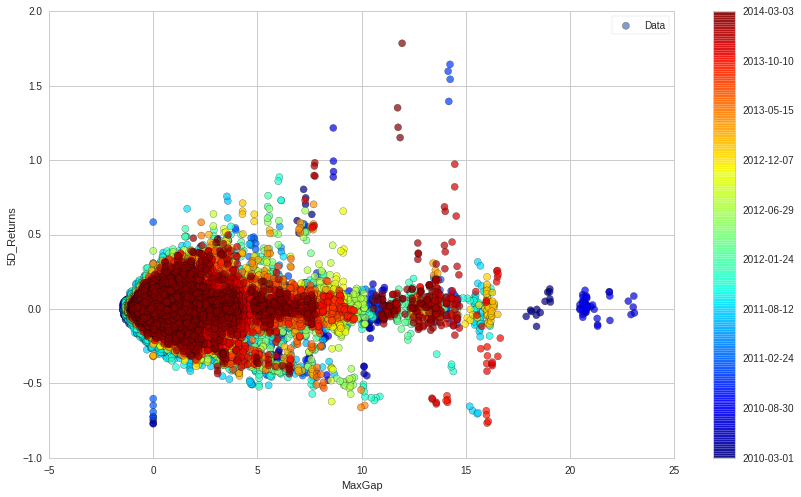

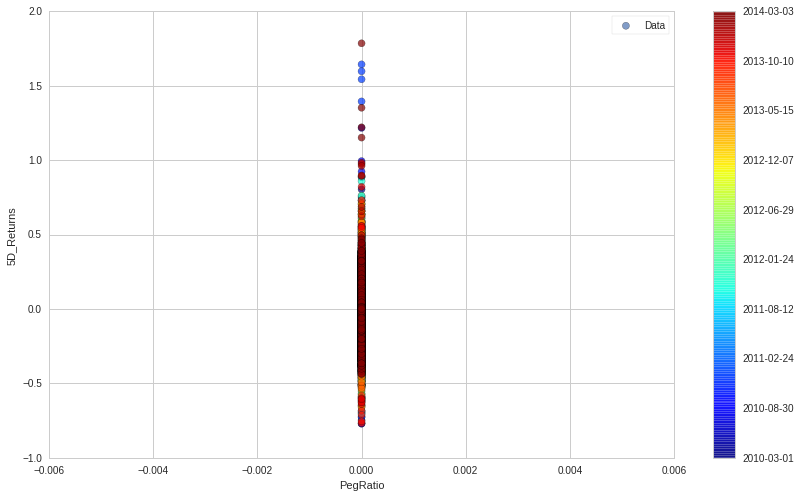

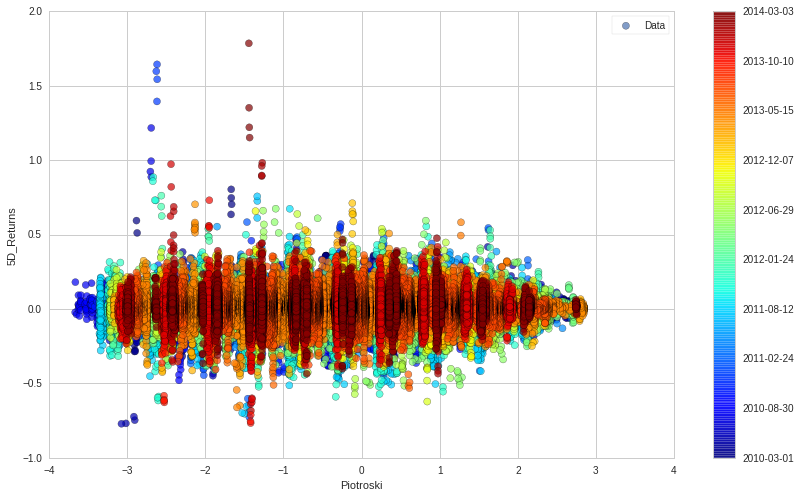

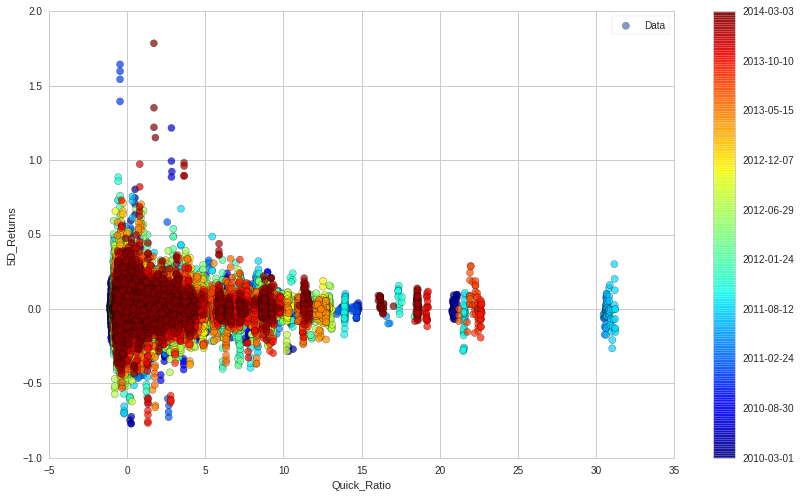

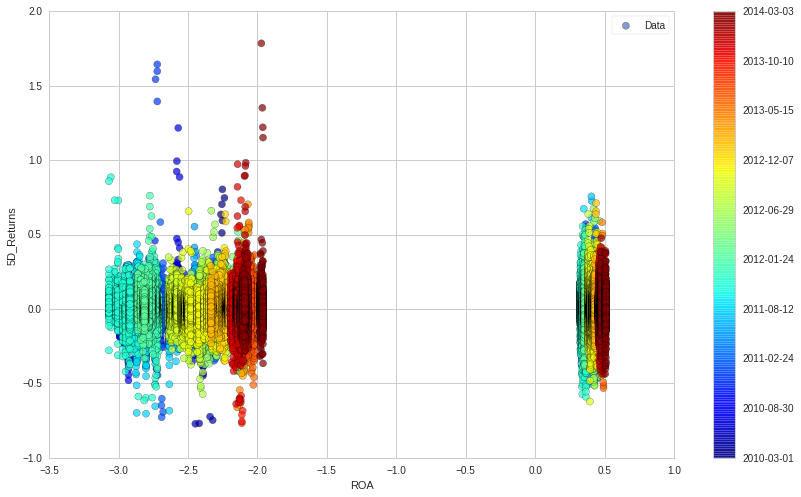

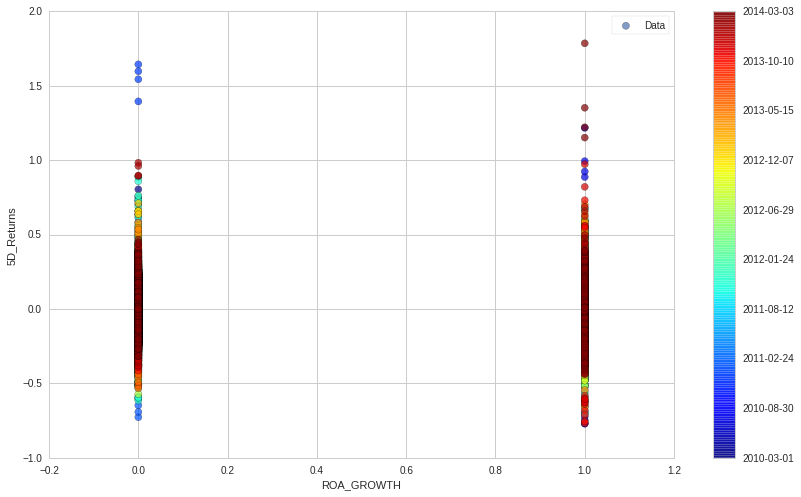

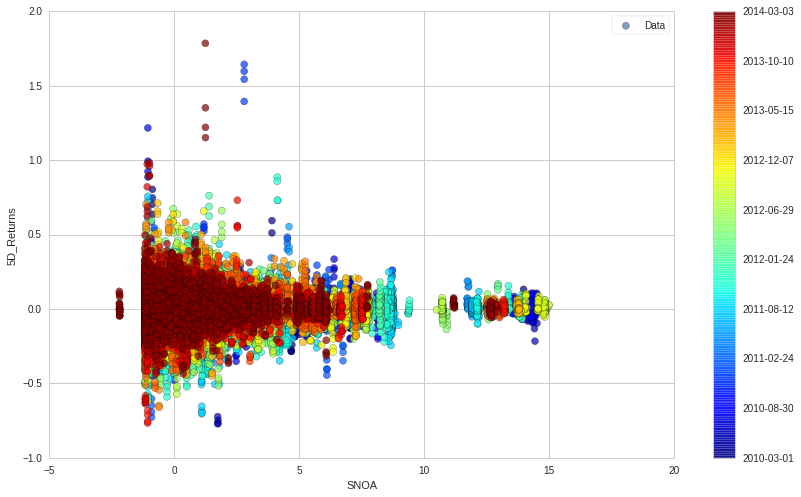

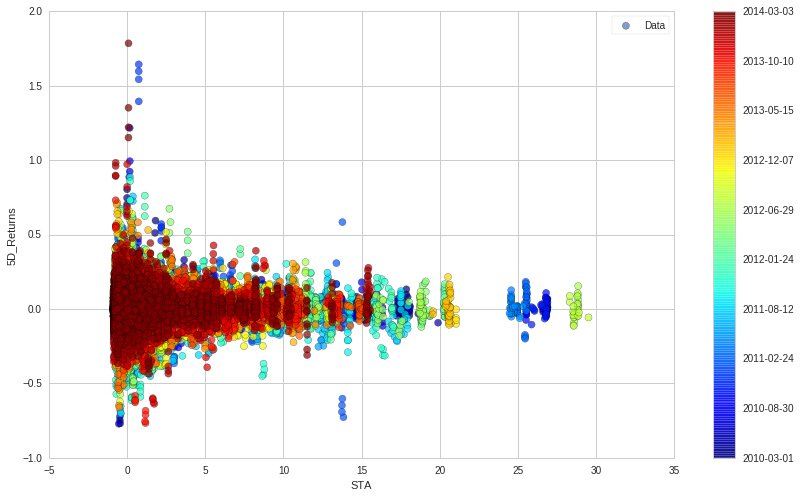

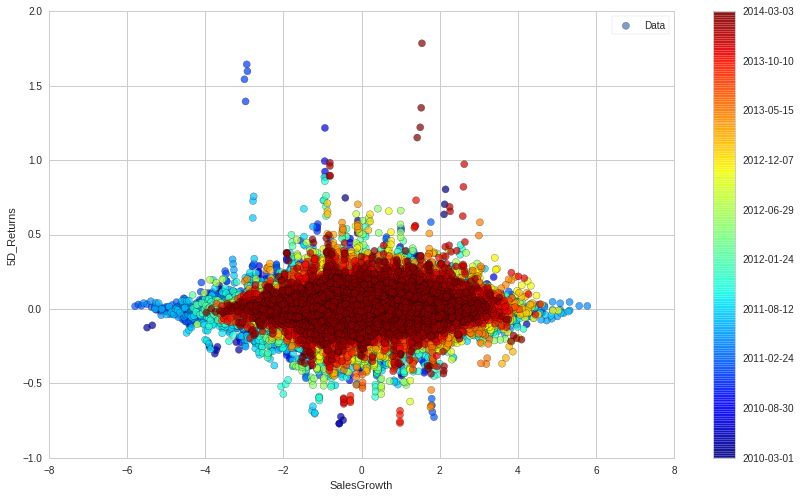

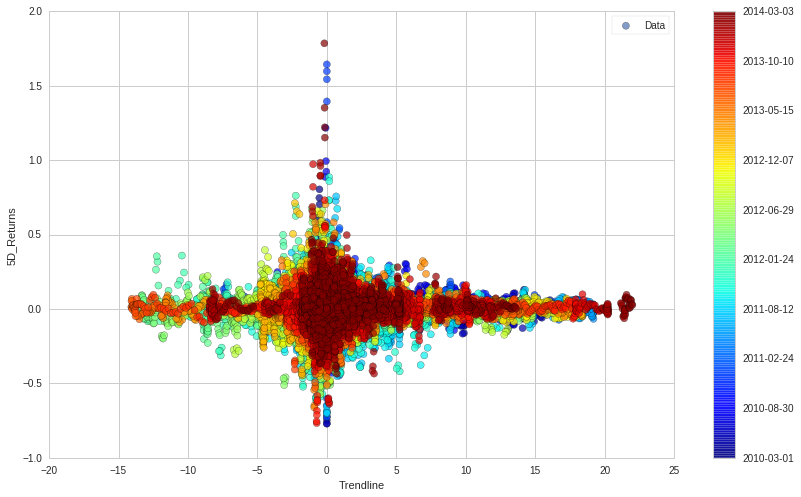

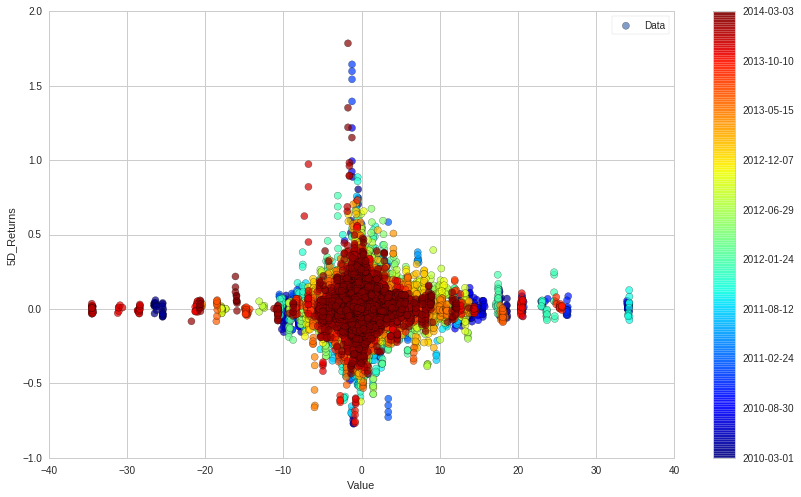

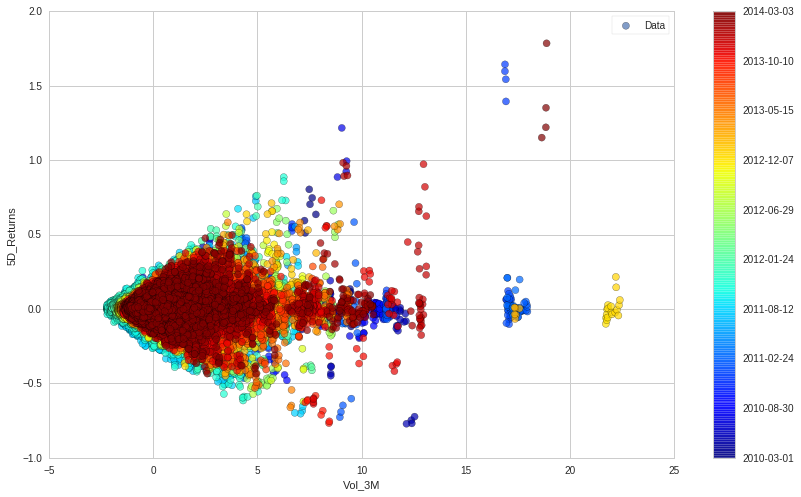

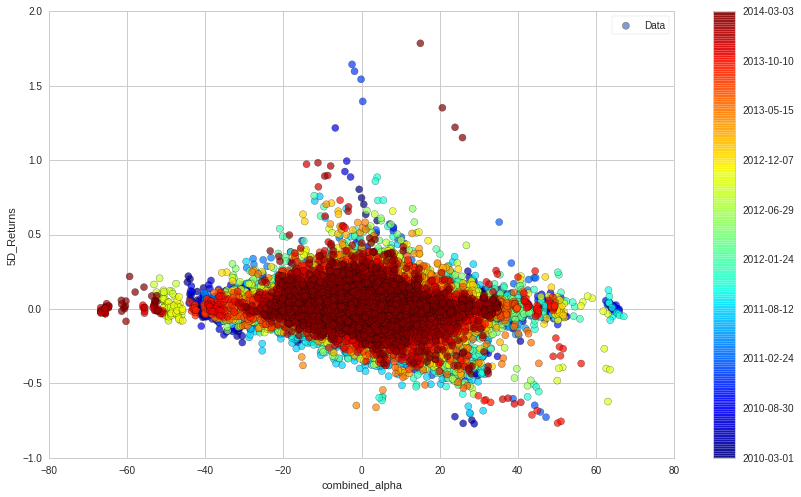

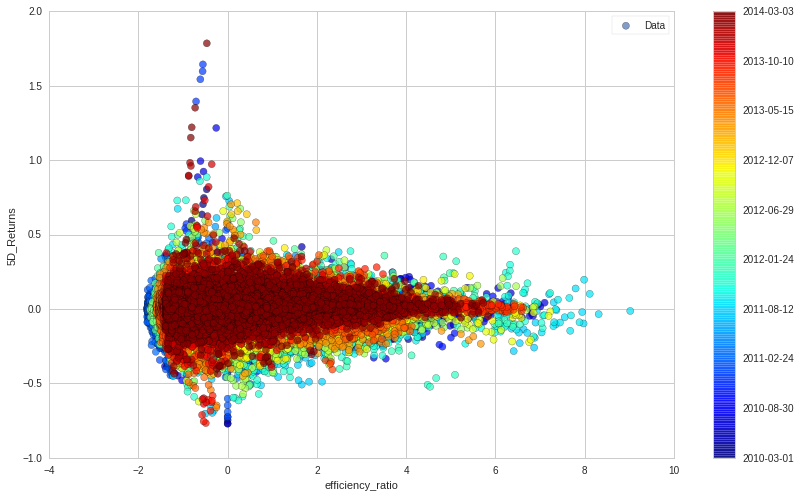

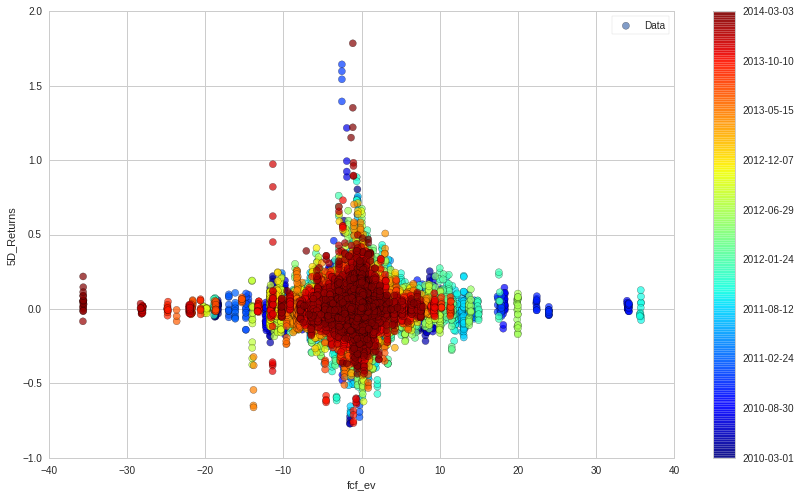

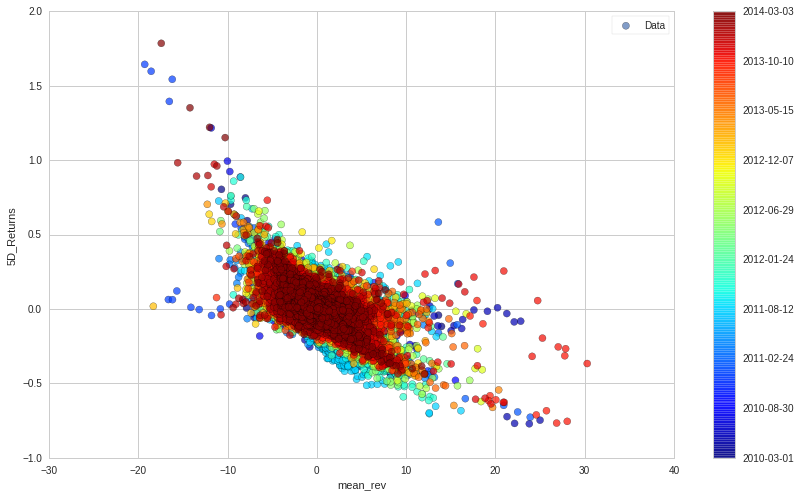

In [28]:
from sklearn.linear_model import LinearRegression

factors = results_s

lm = LinearRegression()

Y = results['5D_Returns']
#plot and linear regression for each factor
for f in factors.columns:
    X = results_s[f]
    b = results_s
    cm = plt.get_cmap('jet')
    colors = np.linspace(0.1, 1, len(results_s))
    sc = plt.scatter(X, Y, s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Data')
    plt.legend()
    cb = plt.colorbar(sc)
    cb.ax.set_yticklabels([str(p.date()) for p in b[::len(b)//9].index])
    plt.xlabel(f)
    plt.ylabel('5D_Returns');
    plt.show();

In [29]:
start = pd.Timestamp("2010-03-01") 
end = pd.Timestamp("2014-03-01")

In [30]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="close_price")
#pricing = get_pricing(assets, start, end, fields="close_price")

In [31]:
results_x = results.drop('Sector', axis=1)
results_x = results_x.drop('5D_Returns', axis=1)
results_x.head()

AdvancedMomentum  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])          -0.817281   
                          Equity(24 [AAPL])         -0.246546   
                          Equity(31 [ABAX])          0.129444   
                          Equity(41 [ARCB])         -0.236623   
                          Equity(52 [ABM])           0.075982   

                                             AverageRangeRatio  CR_GROWTH  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            2.323599   0.688095   
                          Equity(24 [AAPL])           1.858628   0.688095   
                          Equity(31 [ABAX])          -0.253399  -1.453288   
                          Equity(41 [ARCB])          -0.826737  -1.453288   
                          Equity(52 [ABM])            0.174477  -1.453288   

                                             DebtToTotalAssets  Direction  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            0.065062   1.102901   
                          Equity(24 [AAPL])          -0.993202   0.198163   
                          Equity(31 [ABAX])          -1.017420   0.272144   
                          Equity(41 [ARCB])          -0.949232  -0.684024   
                          Equity(52 [ABM])           -0.492917  -0.270927   

                                                  FCF  FCFTA_GROWTH  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])  -0.421663      0.857868   
                          Equity(24 [AAPL]) -0.012076      0.857868   
                          Equity(31 [ABAX]) -0.166194      0.857868   
                          Equity(41 [ARCB]) -0.642651     -1.165681   
                          Equity(52 [ABM])   0.104426      0.857868   

                                             FCFTA_ROA  GM_GROWTH    GP_to_A  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    0.778133   0.788605  -0.929934   
                          Equity(24 [AAPL])   0.778133   0.788605   0.407558   
                          Equity(31 [ABAX])   0.778133   0.788605   0.350851   
                          Equity(41 [ARCB])   0.778133  -1.268062 -11.308187   
                          Equity(52 [ABM])    0.778133  -1.268062  -0.358918   

                                               ...         SNOA       STA  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])     ...     0.380467  0.152123   
                          Equity(24 [AAPL])    ...    -1.031279  0.366004   
                          Equity(31 [ABAX])    ...    -1.024966 -0.322210   
                          Equity(41 [ARCB])    ...    -0.887497  1.440485   
                          Equity(52 [ABM])     ...    -0.585094  0.063139   

                                             SalesGrowth  Trendline     Value  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])      1.321375  -0.267584  0.454202   
                          Equity(24 [AAPL])     1.572358   5.937829  0.174643   
                          Equity(31 [ABAX])     0.549050  -0.146954 -0.257982   
                          Equity(41 [ARCB])     0.205066  -0.407016 -0.875558   
                          Equity(52 [ABM])     -0.683522  -0.428672  0.488575   

                                               Vol_3M  combined_alpha  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])   1.507994        2.277996   
                          Equity(24 [AAPL]) -0.268974       16.349928   
                          Equity(31 [ABAX])  0.386952        1.840453   
                          Equity(41 [ARCB])  1.688185      -20.532475   
                          Equity(52 [ABM])  -0.099469       -0.441426   

                                             efficiency_ratio    fcf_ev  \
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])          -0.893107 -0.669354   
                          Equity(24 [AAPL])          0.806395  0.125801   
                          Equity(31 [ABAX])         -0.668185 -0.222379   
                          Equity(41 [ARCB])         -0.316913 -1.280883   
                          Equity(52 [ABM])          -0.6

In [32]:
df_ab = []
df_ic = []
df_mu = []
cols = []

for col in results_x.columns:
    try:
        factor_data = al.utils.get_clean_factor_and_forward_returns(results_x[col], pricing)
    except:
        print('Some problem with %s' % col)
        continue
    
    cols.append(col)
    ab = al.performance.factor_alpha_beta(factor_data)
    ic = al.performance.mean_information_coefficient(factor_data)
    
    # replicate what the full tearsheet shows under "Returns Analysis"
    DECIMAL_TO_BPS = 10000
    mu, sigma = al.performance.mean_return_by_quantile(factor_data)
    mu = mu.apply(al.utils.rate_of_return, axis=0, base_period=mu.columns[0])
    topbot = (mu * DECIMAL_TO_BPS).iloc[[-1, 0]]
    
    df_ab.append(ab)
    df_ic.append(ic)
    df_mu.append(topbot)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 100.0% entries from factor data: 0.0% in forward returns computation and 100.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Some problem with CR_GROWTH
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries

In [33]:
fs = (14, 12)

In [34]:
def plot_top_bot(period='5D'):
    df0 = pd.DataFrame([df.loc[1, period] for df in df_mu], index=cols, columns=['Bottom quantile'])
    df1 = pd.DataFrame([df.loc[5, period] for df in df_mu], index=cols, columns=['Top quantile'])
    df = pd.concat((df0, df1), 1)
    df.plot(kind='barh', title='Mean %s Returns (bps) for top & bottom quantiles ' % period, figsize=fs);
    return df

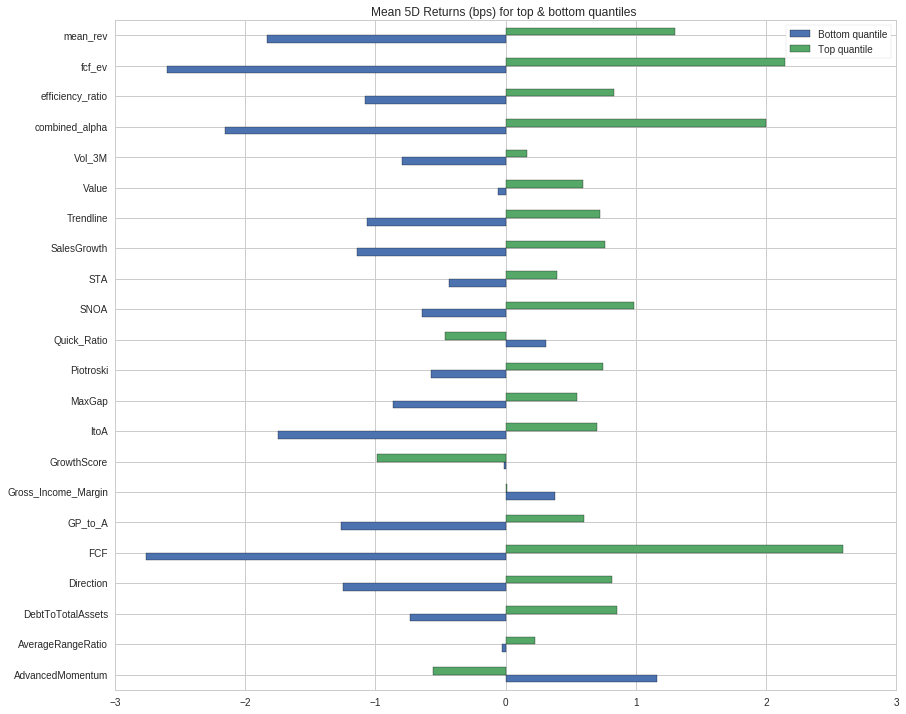

In [35]:
df = plot_top_bot(period='5D')

In [36]:
df['abs_diff'] = np.abs(df.iloc[:,1] - df.iloc[:,0])
df.sort_values(by=['abs_diff'], ascending=False)

Bottom quantile  Top quantile  abs_diff
FCF                        -2.759445      2.589795  5.349240
fcf_ev                     -2.604105      2.148657  4.752762
combined_alpha             -2.159149      2.001033  4.160182
mean_rev                   -1.831287      1.297364  3.128651
ItoA                       -1.746349      0.700637  2.446986
Direction                  -1.247863      0.820378  2.068240
efficiency_ratio           -1.082983      0.828236  1.911219
SalesGrowth                -1.143952      0.760601  1.904553
GP_to_A                    -1.264331      0.601535  1.865866
Trendline                  -1.066539      0.722448  1.788987
AdvancedMomentum            1.163200     -0.558892  1.722092
SNOA                       -0.644380      0.988916  1.633296
DebtToTotalAssets          -0.732915      0.851442  1.584357
MaxGap                     -0.868711      0.546057  1.414768
Piotroski                  -0.577010      0.746411  1.323420
GrowthScore                -0.012601     -0.990718  0.978117
Vol_3M                     -0.799845      0.162146  0.961991
STA                        -0.434711      0.392700  0.827411
Quick_Ratio                 0.306857     -0.464643  0.771500
Value                      -0.056047      0.595314  0.651361
Gross_Income_Margin         0.381690      0.007723  0.373967
AverageRangeRatio          -0.030659      0.224952  0.255611

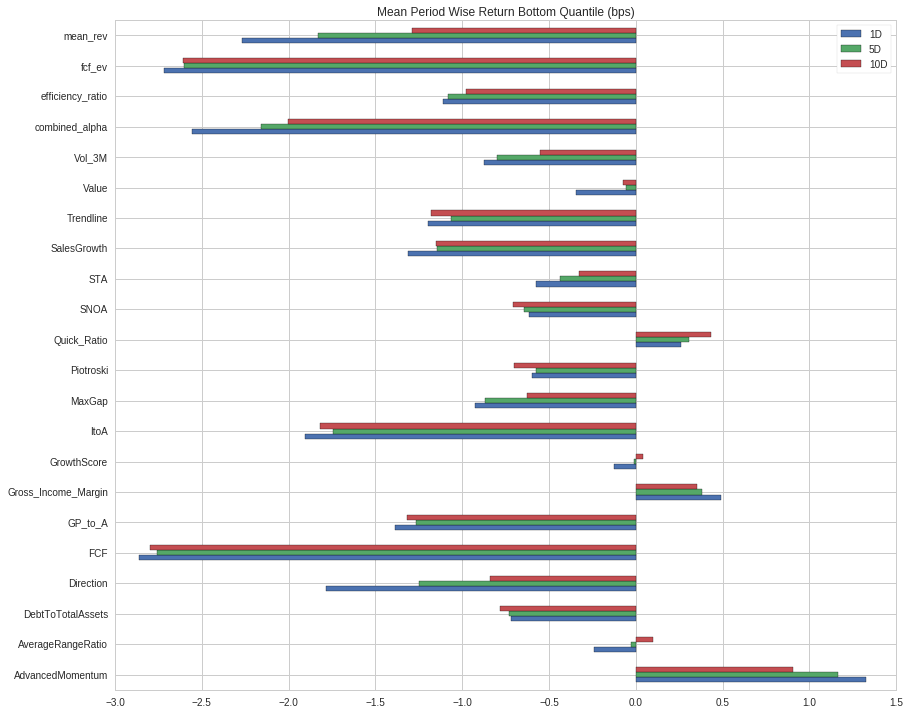

In [37]:
df = pd.concat([df.loc[1] for df in df_mu], 1)
df.columns = cols
df.T.plot(kind='barh', title='Mean Period Wise Return Bottom Quantile (bps)', figsize=fs);

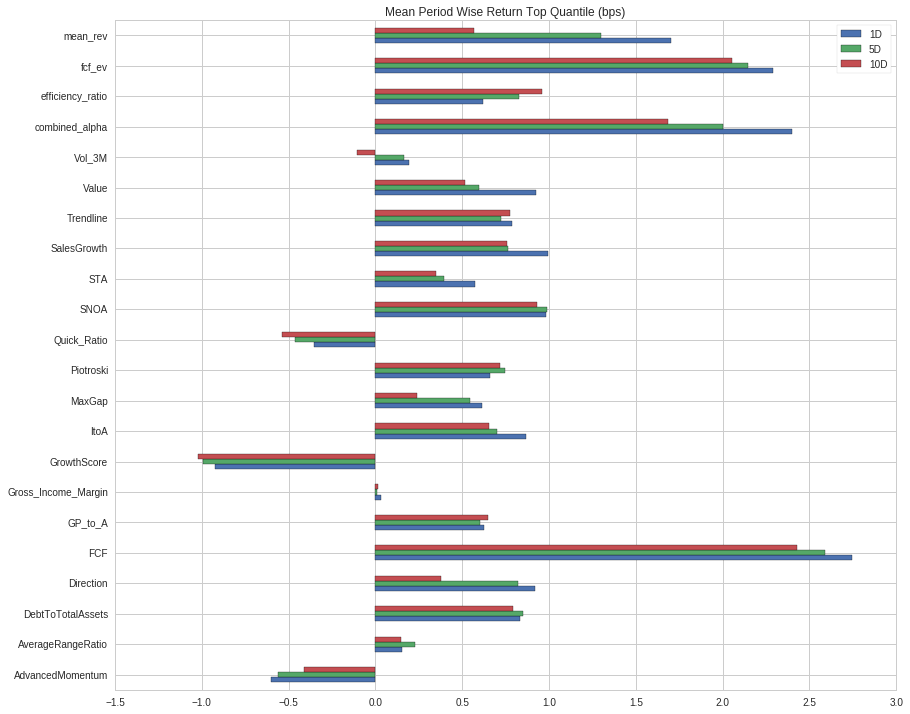

In [38]:
df = pd.concat([df.loc[5] for df in df_mu], 1)
df.columns = cols
df.T.plot(kind='barh', title='Mean Period Wise Return Top Quantile (bps)', figsize=fs);

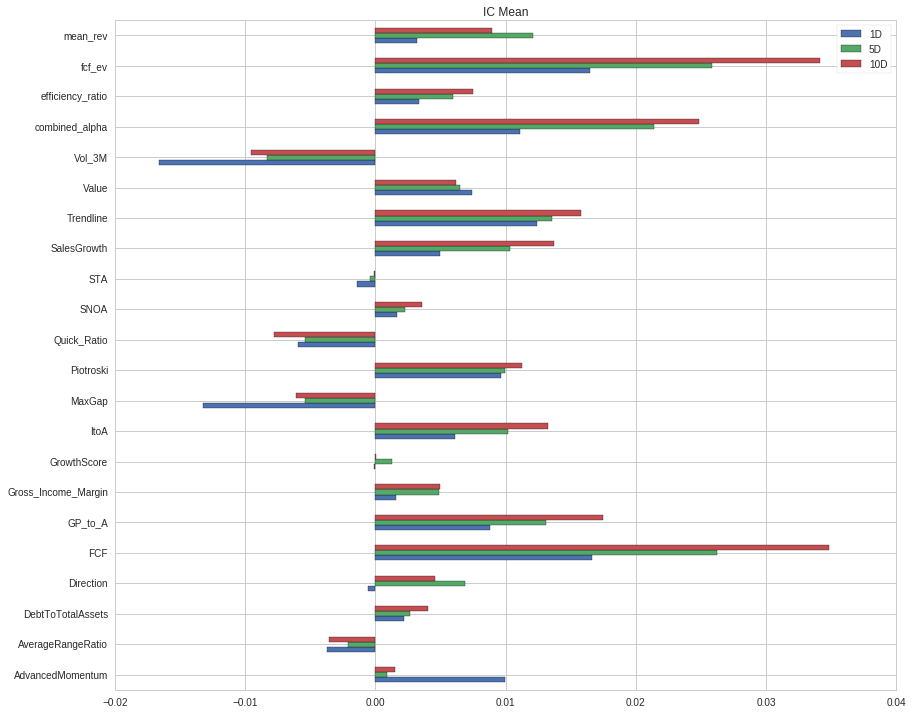

In [39]:
df = pd.concat(df_ic, 1)
df.columns = cols
df.T.plot(kind='barh', title='IC Mean', figsize=fs);

In [40]:
#alpha = results['combined_alpha']
#rets = results['5D_Returns']

In [41]:
results_n = results.drop('Sector', axis=1)
results_n.dropna(inplace=True)
results_n.head()

5D_Returns  AdvancedMomentum  \
date                      asset                                             
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    -0.016987         -0.817281   
                          Equity(24 [AAPL])    0.020954         -0.246546   
                          Equity(31 [ABAX])   -0.021965          0.129444   
                          Equity(41 [ARCB])    0.035108         -0.236623   
                          Equity(52 [ABM])    -0.013976          0.075982   

                                             AverageRangeRatio  CR_GROWTH  \
date                      asset                                             
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            2.323599   0.688095   
                          Equity(24 [AAPL])           1.858628   0.688095   
                          Equity(31 [ABAX])          -0.253399  -1.453288   
                          Equity(41 [ARCB])          -0.826737  -1.453288   
                          Equity(52 [ABM])            0.174477  -1.453288   

                                             DebtToTotalAssets  Direction  \
date                      asset                                             
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            0.065062   1.102901   
                          Equity(24 [AAPL])          -0.993202   0.198163   
                          Equity(31 [ABAX])          -1.017420   0.272144   
                          Equity(41 [ARCB])          -0.949232  -0.684024   
                          Equity(52 [ABM])           -0.492917  -0.270927   

                                                  FCF  FCFTA_GROWTH  \
date                      asset                                       
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])  -0.421663      0.857868   
                          Equity(24 [AAPL]) -0.012076      0.857868   
                          Equity(31 [ABAX]) -0.166194      0.857868   
                          Equity(41 [ARCB]) -0.642651     -1.165681   
                          Equity(52 [ABM])   0.104426      0.857868   

                                             FCFTA_ROA  GM_GROWTH    ...     \
date                      asset                                      ...      
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    0.778133   0.788605    ...      
                          Equity(24 [AAPL])   0.778133   0.788605    ...      
                          Equity(31 [ABAX])   0.778133   0.788605    ...      
                          Equity(41 [ARCB])   0.778133  -1.268062    ...      
                          Equity(52 [ABM])    0.778133  -1.268062    ...      

                                                 SNOA       STA  SalesGrowth  \
date                      asset                                                
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])   0.380467  0.152123     1.321375   
                          Equity(24 [AAPL]) -1.031279  0.366004     1.572358   
                          Equity(31 [ABAX]) -1.024966 -0.322210     0.549050   
                          Equity(41 [ARCB]) -0.887497  1.440485     0.205066   
                          Equity(52 [ABM])  -0.585094  0.063139    -0.683522   

                                             Trendline     Value    Vol_3M  \
date                      asset                                              
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])   -0.267584  0.454202  1.507994   
                          Equity(24 [AAPL])   5.937829  0.174643 -0.268974   
                          Equity(31 [ABAX])  -0.146954 -0.257982  0.386952   
                          Equity(41 [ARCB])  -0.407016 -0.875558  1.688185   
                          Equity(52 [ABM])   -0.428672  0.488575 -0.099469   

                                             combined_alpha  efficiency_ratio  \
date                      asset                                                 
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])         2.277996         -0.893107   
                      

In [42]:
alpha_n = results_n['combined_alpha']
rets_n = results_n['5D_Returns']

In [43]:
rets = results['5D_Returns']
alpha = results['combined_alpha']

In [44]:
print(alpha_n.describe().loc[['mean', 'std', 'min', 'max']])

mean     0.523770
std      6.168626
min    -66.801615
max     67.130710
Name: combined_alpha, dtype: float64


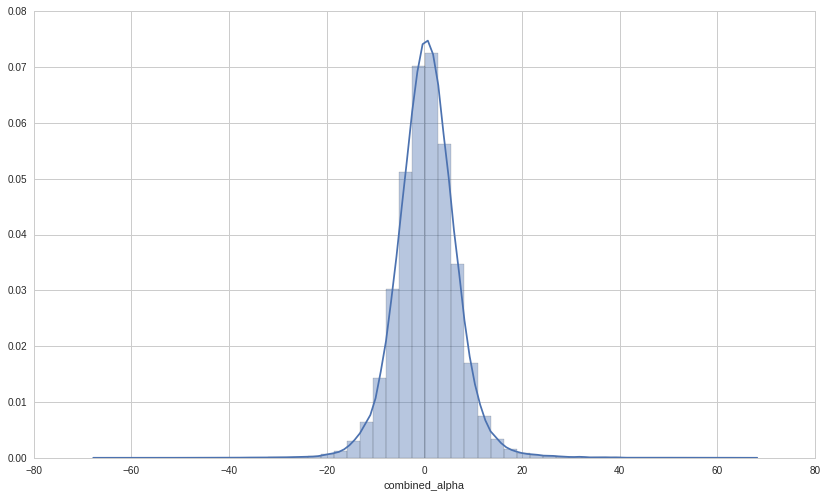

In [45]:
import seaborn as sns
sns.distplot(alpha_n);

In [46]:
r_s = stats.spearmanr(alpha_n, rets_n)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

Correlation Coefficient: -0.083685281391
p-value: 0.0


In [47]:
x = sm.add_constant(rets_n, prepend=False)
ols = sm.OLS(alpha_n, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [48]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.012       
Dependent Variable: combined_alpha   AIC:                8498589.7560
Date:               2019-04-26 02:40 BIC:                8498613.9341
No. Observations:   1314578          Log-Likelihood:     -4.2493e+06 
Df Model:           1                F-statistic:        1.580e+04   
Df Residuals:       1314576          Prob (F-statistic): 0.00        
R-squared:          0.012            Scale:              37.600      
----------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025    0.975] 
----------------------------------------------------------------------
5D_Returns   -14.3255    0.1139  -125.7174  0.0000  -14.5488  -14.1021
const          0.5678    0.0054   105.9368  0.0000    0.5573    0.5783
---------------------------------------------------------------------
Omnibus:            125440.537      Durbin-Watson:         1.998     
Prob(Omnibus):      0.000           Jarque-Bera (JB):      852227.846
Skew:               0.184           Prob(JB):              0.000     
Kurtosis:           6.927           Condition No.:         21        
=====================================================================

"""

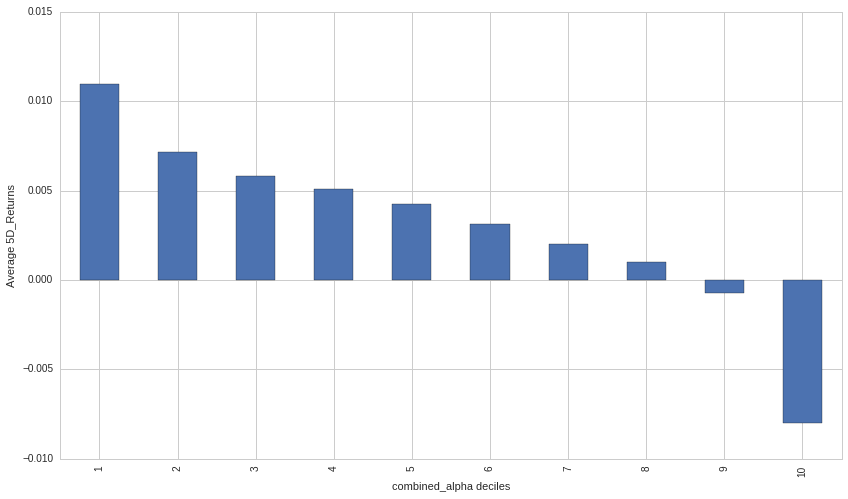

In [49]:
results = results.dropna()
results['decile']=pd.qcut(results['combined_alpha'],10,labels=False)+1
quantile_averages=results.groupby('decile')['5D_Returns'].apply(lambda x: x.mean())
quantile_averages.plot(kind='bar')
plt.xlabel('combined_alpha deciles')
plt.ylabel('Average 5D_Returns');

In [50]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Mtrls',
    102: 'Cnsmr Cyc',
    103: 'Fin Svs',
    104: 'Real Estate',
    205: 'Cnsmr Def',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Comm Svs',
    309: 'Energy',
    310: 'Ind',
    311: 'Tech' ,    
}

In [51]:
results['Sector_Name'] = results['Sector'].map(MORNINGSTAR_SECTOR_CODES)
results.head()

5D_Returns  AdvancedMomentum  \
date                      asset                                             
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    -0.016987         -0.817281   
                          Equity(24 [AAPL])    0.020954         -0.246546   
                          Equity(31 [ABAX])   -0.021965          0.129444   
                          Equity(41 [ARCB])    0.035108         -0.236623   
                          Equity(52 [ABM])    -0.013976          0.075982   

                                             AverageRangeRatio  CR_GROWTH  \
date                      asset                                             
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            2.323599   0.688095   
                          Equity(24 [AAPL])           1.858628   0.688095   
                          Equity(31 [ABAX])          -0.253399  -1.453288   
                          Equity(41 [ARCB])          -0.826737  -1.453288   
                          Equity(52 [ABM])            0.174477  -1.453288   

                                             DebtToTotalAssets  Direction  \
date                      asset                                             
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])            0.065062   1.102901   
                          Equity(24 [AAPL])          -0.993202   0.198163   
                          Equity(31 [ABAX])          -1.017420   0.272144   
                          Equity(41 [ARCB])          -0.949232  -0.684024   
                          Equity(52 [ABM])           -0.492917  -0.270927   

                                                  FCF  FCFTA_GROWTH  \
date                      asset                                       
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])  -0.421663      0.857868   
                          Equity(24 [AAPL]) -0.012076      0.857868   
                          Equity(31 [ABAX]) -0.166194      0.857868   
                          Equity(41 [ARCB]) -0.642651     -1.165681   
                          Equity(52 [ABM])   0.104426      0.857868   

                                             FCFTA_ROA  GM_GROWTH  \
date                      asset                                     
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])    0.778133   0.788605   
                          Equity(24 [AAPL])   0.778133   0.788605   
                          Equity(31 [ABAX])   0.778133   0.788605   
                          Equity(41 [ARCB])   0.778133  -1.268062   
                          Equity(52 [ABM])    0.778133  -1.268062   

                                                ...       Sector  Trendline  \
date                      asset                 ...                           
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])      ...          101  -0.267584   
                          Equity(24 [AAPL])     ...          311   5.937829   
                          Equity(31 [ABAX])     ...          206  -0.146954   
                          Equity(41 [ARCB])     ...          310  -0.407016   
                          Equity(52 [ABM])      ...          310  -0.428672   

                                                Value    Vol_3M  \
date                      asset                                   
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])   0.454202  1.507994   
                          Equity(24 [AAPL])  0.174643 -0.268974   
                          Equity(31 [ABAX]) -0.257982  0.386952   
                          Equity(41 [ARCB]) -0.875558  1.688185   
                          Equity(52 [ABM])   0.488575 -0.099469   

                                             combined_alpha  efficiency_ratio  \
date                      asset                                                 
2010-03-01 00:00:00+00:00 Equity(2 [ARNC])         2.277996         -0.893107   
                          Equity(24 [AAPL])       16.349928          0.806395   
                          Equity(31 [ABAX])        1.840453         -0.668185   
              

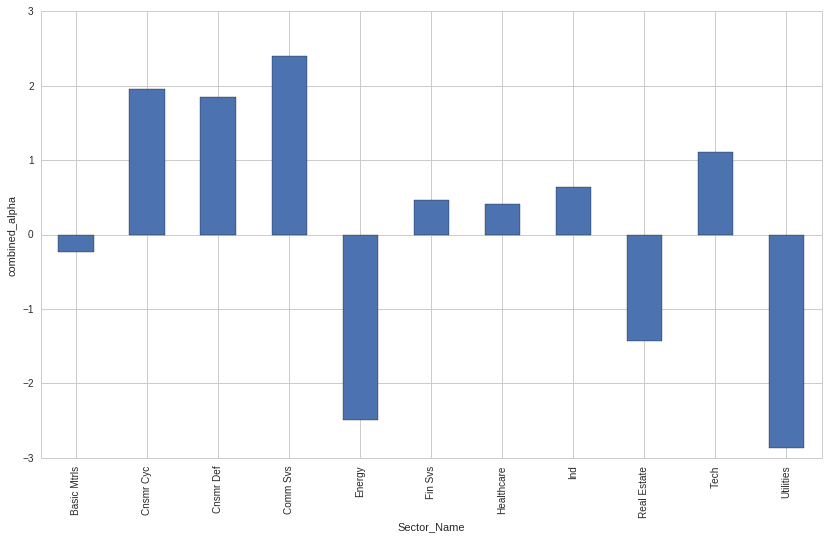

In [52]:
sector_averages = results.groupby('Sector_Name')['combined_alpha'].apply(lambda x: x.mean())
plt.ylabel('combined_alpha')
sector_averages.plot(kind='bar');

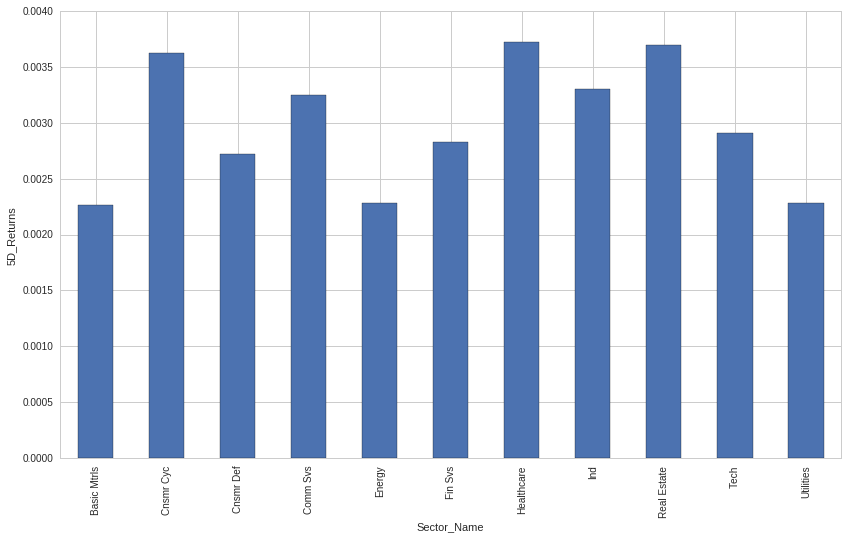

In [53]:
sector_averages = results.groupby('Sector_Name')['5D_Returns'].apply(lambda x: x.mean())
plt.ylabel('5D_Returns')
sector_averages.plot(kind='bar');

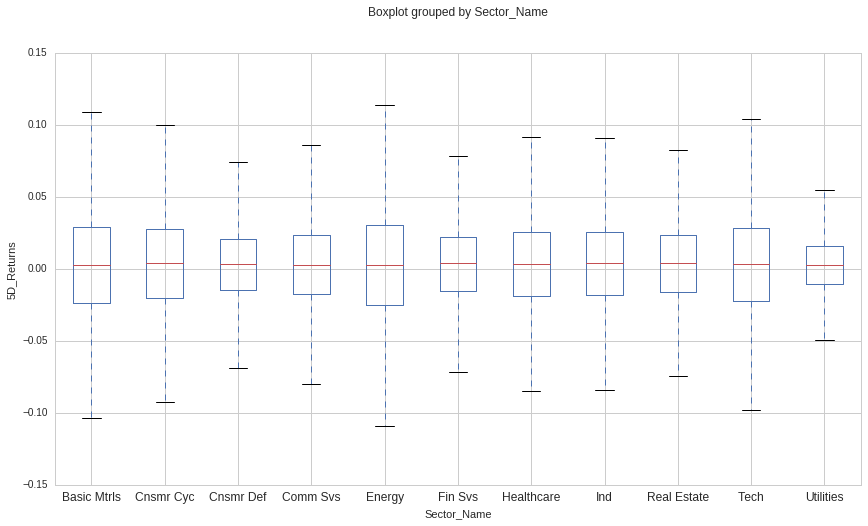

In [54]:
results.boxplot(column='5D_Returns',by='Sector_Name')
plt.ylabel('5D_Returns')
plt.title('')
plt.ylim(-0.15,0.15);

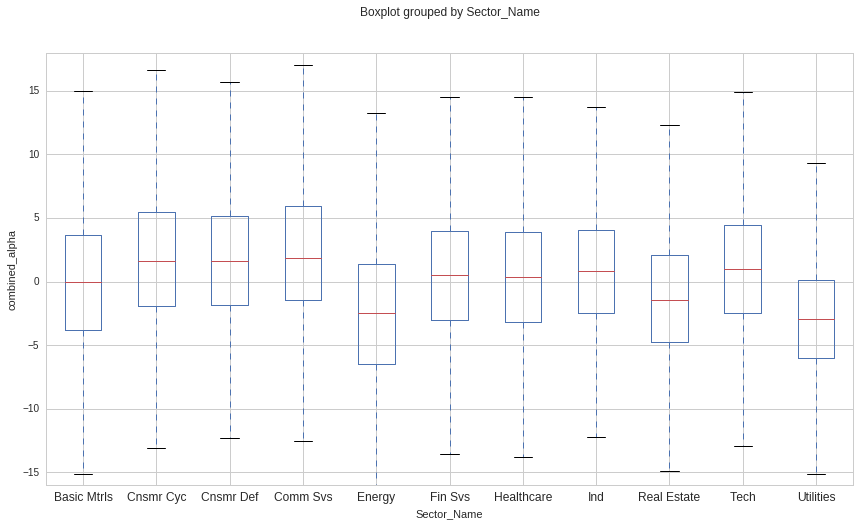

In [58]:
results.boxplot(column='combined_alpha',by='Sector_Name')
plt.ylabel('combined_alpha')
plt.title('')
plt.ylim(-16,18);

In [59]:
from quantopian.research.experimental import get_factor_returns, get_factor_loadings
import empyrical as ep

In [60]:
stock_rets = pricing.pct_change()

In [61]:
def plot_ic_over_time(factor_data, label='', ax=None):
    mic = al.performance.mean_information_coefficient(factor_data)
    mic.index = mic.index.map(lambda x: int(x[:-1])) 
    ax = mic.plot(label=label, ax=ax)
    ax.set(xlabel='Days', ylabel='Mean IC')
    ax.legend()
    ax.axhline(0, ls='--', color='k')

In [62]:
# Use alphalens to combine factor values with forward returns
factor_data_total = al.utils.get_clean_factor_and_forward_returns(
    results['combined_alpha'], 
    pricing,
    periods=range(1, 15))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


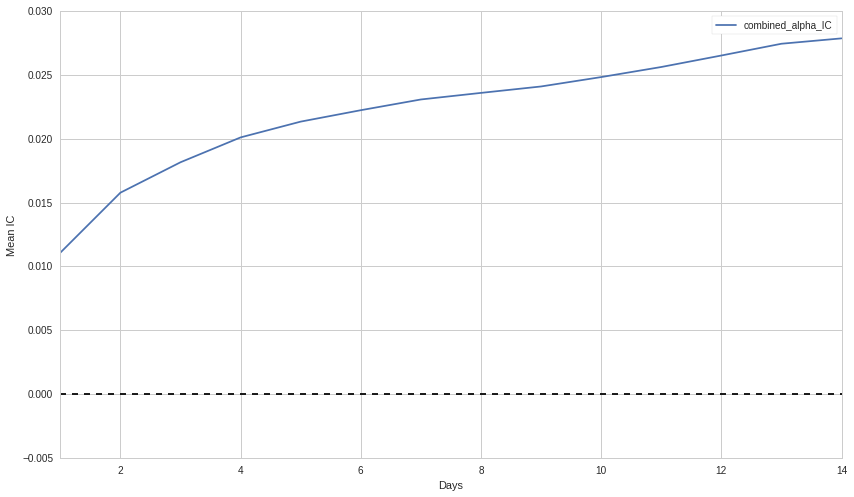

In [63]:
plot_ic_over_time(factor_data_total, label='combined_alpha_IC')

In [64]:
# Load risk factor loadings and returns
factor_loadings = get_factor_loadings(assets, start, end + pd.Timedelta(days=30))
factor_returns = get_factor_returns(start, end + pd.Timedelta(days=30))

In [65]:
def compute_specific_returns(total_returns, factor_returns=None, factor_loadings=None, assets=None):
    if assets is not None:
        factor_loadings = get_factor_loadings(assets, start, end + pd.Timedelta(days=30))
        factor_returns = get_factor_returns(start, end + pd.Timedelta(days=30))
    elif factor_loadings is None or factor_returns is None:
        raise ValueError('Supply either assets or factor_returns and factor_loadings')
    
    factor_returns.index = factor_returns.index.set_names(['dt'])
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    common_returns = factor_loadings.mul(factor_returns).sum(axis='columns').unstack()
    specific_returns = total_returns - common_returns
    return specific_returns

In [66]:
stock_rets_specific = compute_specific_returns(stock_rets, factor_returns, factor_loadings)

In [67]:
cr_specific = ep.cum_returns(stock_rets_specific, starting_value=1)

In [68]:
factor_data_specific = al.utils.get_clean_factor_and_forward_returns(
    results['combined_alpha'], 
    cr_specific,
    periods=range(1, 15))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


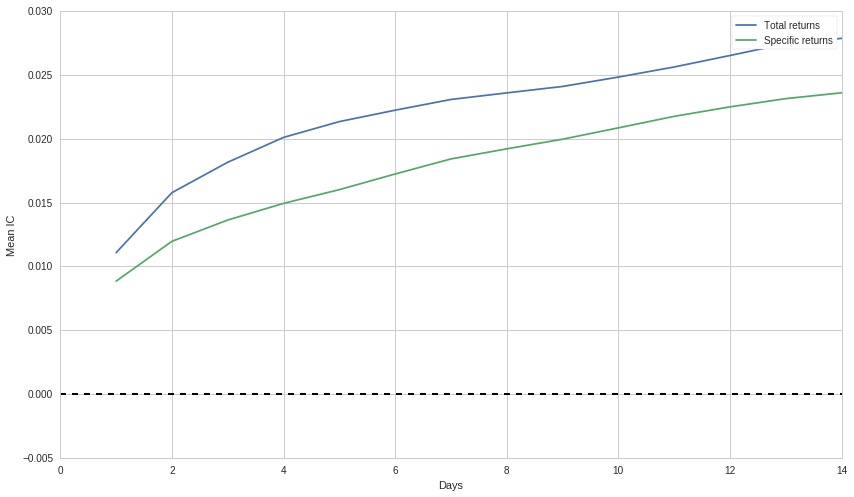

In [69]:
plot_ic_over_time(factor_data_total, label='Total returns')
plot_ic_over_time(factor_data_specific, label='Specific returns')

In [70]:
def factor_portfolio_returns(factor, pricing, equal_weight=True, delay=0):
    if equal_weight:
        factor = np.sign(factor)
        bins = (-1, 0, 1)
        quantiles = None
        zero_aware = False
    else:
        bins = None
        quantiles = 5
        zero_aware = True
        
    pos = factor.unstack().fillna(0)
    # Factor might not be daily, get trading index from pricing data and ffill
    pos = (pos / (pos.abs().sum())).reindex(pricing.index).ffill().shift(delay)
    # Fully invested, shorts show up as cash
    pos['cash'] = pos[pos < 0].sum(axis='columns')
    
    factor_and_returns = al.utils.get_clean_factor_and_forward_returns(
        pos.stack().loc[lambda x: x != 0], 
        pricing, periods=(1,), quantiles=quantiles, bins=bins, 
        zero_aware=zero_aware)
    
    return al.performance.factor_returns(factor_and_returns)['1D'], pos

portfolio_returns, portfolio_pos = factor_portfolio_returns(results['combined_alpha'], pricing, 
                                                             equal_weight=True)

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [71]:
factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
risk_exposures_portfolio, perf_attribution = pf.perf_attrib.perf_attrib(
    portfolio_returns, 
    portfolio_pos, 
    factor_returns, 
    factor_loadings, 
    pos_in_dollars=False)

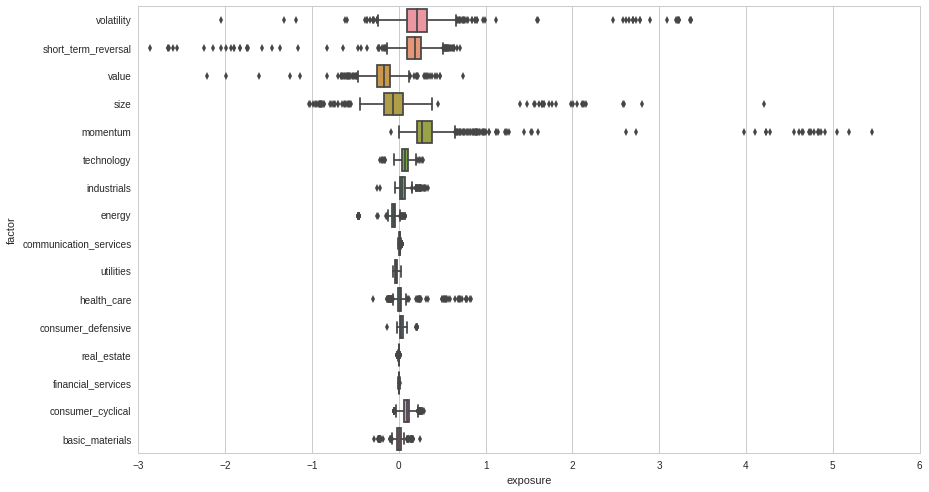

In [72]:
def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])
    
plot_exposures(risk_exposures_portfolio)

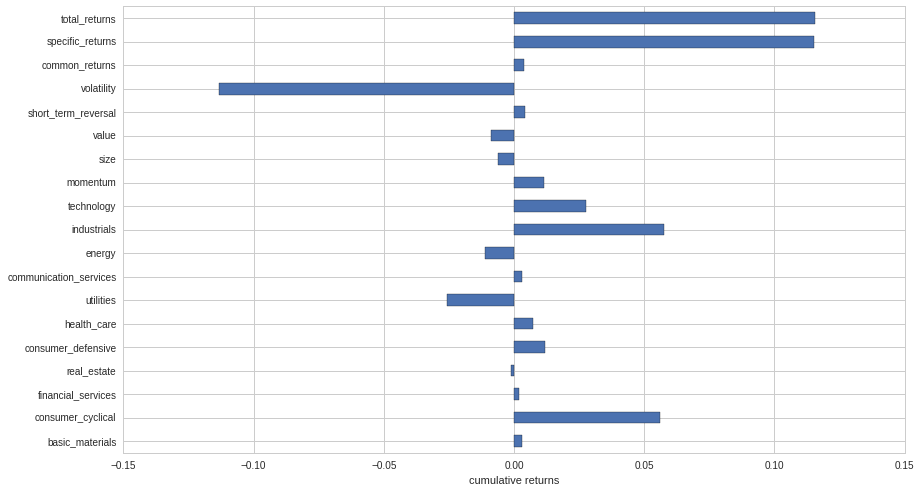

In [73]:
ep.cum_returns_final(perf_attribution).plot.barh()
plt.xlabel('cumulative returns');

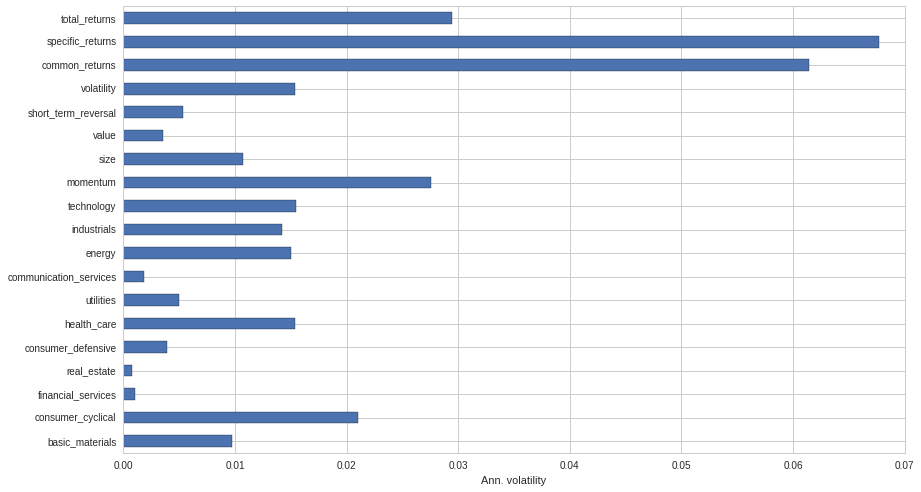

In [74]:
perf_attribution.apply(ep.annual_volatility).plot.barh()
plt.xlabel('Ann. volatility');

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


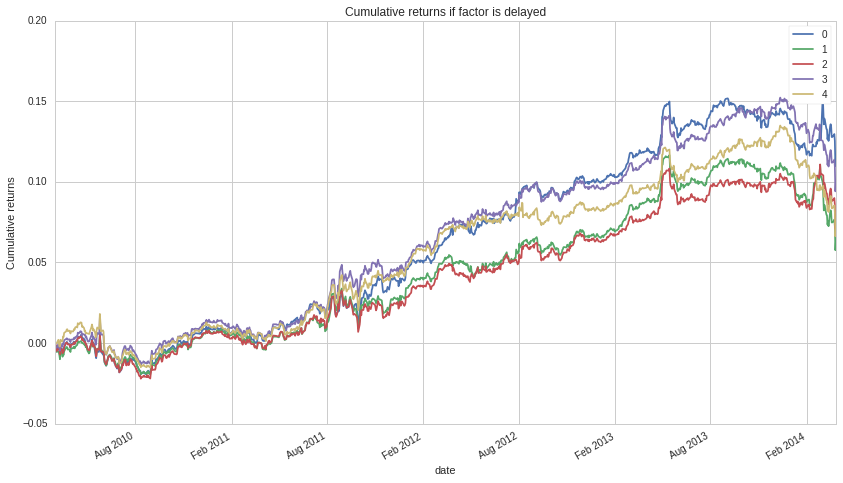

In [75]:
def plot_cum_returns_delay(factor, pricing, delay=range(5), ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for d in delay:
        portfolio_returns, _ = factor_portfolio_returns(results['combined_alpha'], pricing, delay=d)
        ep.cum_returns(portfolio_returns).plot(ax=ax, label=d)
    ax.legend()
    ax.set(ylabel='Cumulative returns', title='Cumulative returns if factor is delayed')
    
plot_cum_returns_delay(results['combined_alpha'], pricing)

In [78]:
my_factor = results['combined_alpha']
sectors = results['Sector']
asset_list = results.index.levels[1].unique()
prices = pricing
periods = (1,3,5,10,21)

factor_data = al.utils.get_clean_factor_and_forward_returns(factor=my_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods,
                                                            quantiles = 5)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [79]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data,
                                                                                    by_date=True)
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data,
                                                                        by_group=False)

In [ ]:
al.tears.create_event_returns_tear_sheet(factor_data=factor_data,
                                                        prices=prices,
                                                        avgretplot=(5, 20),
                                                        long_short=True,
                                                        by_group=True);

Quantiles Statistics


min        max      mean       std   count    count %
factor_quantile                                                             
1               -66.801615  -3.397276 -7.722864  3.798482  262995  20.031945
2                -4.995722  -0.424588 -2.376196  0.946152  262356  19.983273
3                -1.343162   2.399444  0.482545  0.793808  262384  19.985406
4                 1.364364   5.874488  3.346314  0.952100  262356  19.983273
5                 4.382110  67.130710  8.895363  4.329158  262787  20.016102

Returns Analysis


1D     3D     5D    10D  \
Ann. alpha                                     0.050  0.045  0.043  0.042   
beta                                           0.055  0.049  0.045  0.027   
Mean Period Wise Return Top Quantile (bps)     2.382  2.147  1.996  1.683   
Mean Period Wise Return Bottom Quantile (bps) -2.554 -2.297 -2.141 -1.997   
Mean Period Wise Spread (bps)                  4.936  4.442  4.137  3.683   

                                                 21D  
Ann. alpha                                     0.037  
beta                                           0.033  
Mean Period Wise Return Top Quantile (bps)     1.387  
Mean Period Wise Return Bottom Quantile (bps) -1.951  
Mean Period Wise Spread (bps)                  3.340

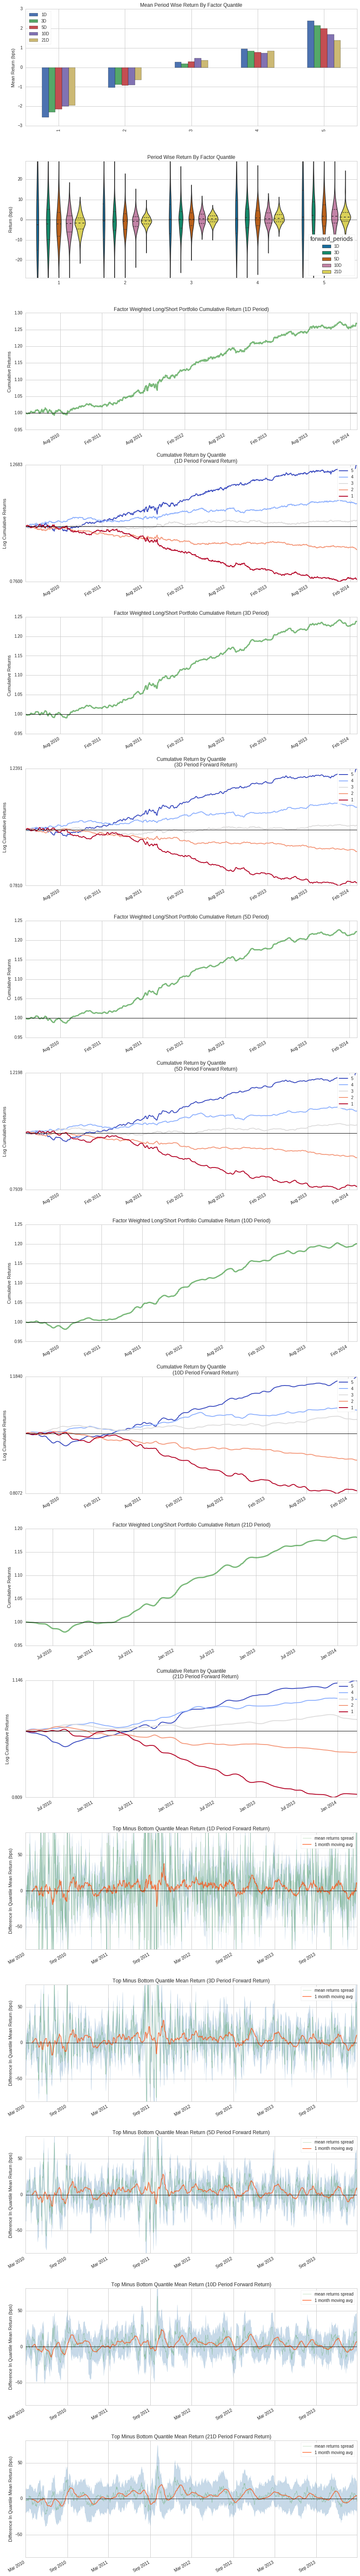

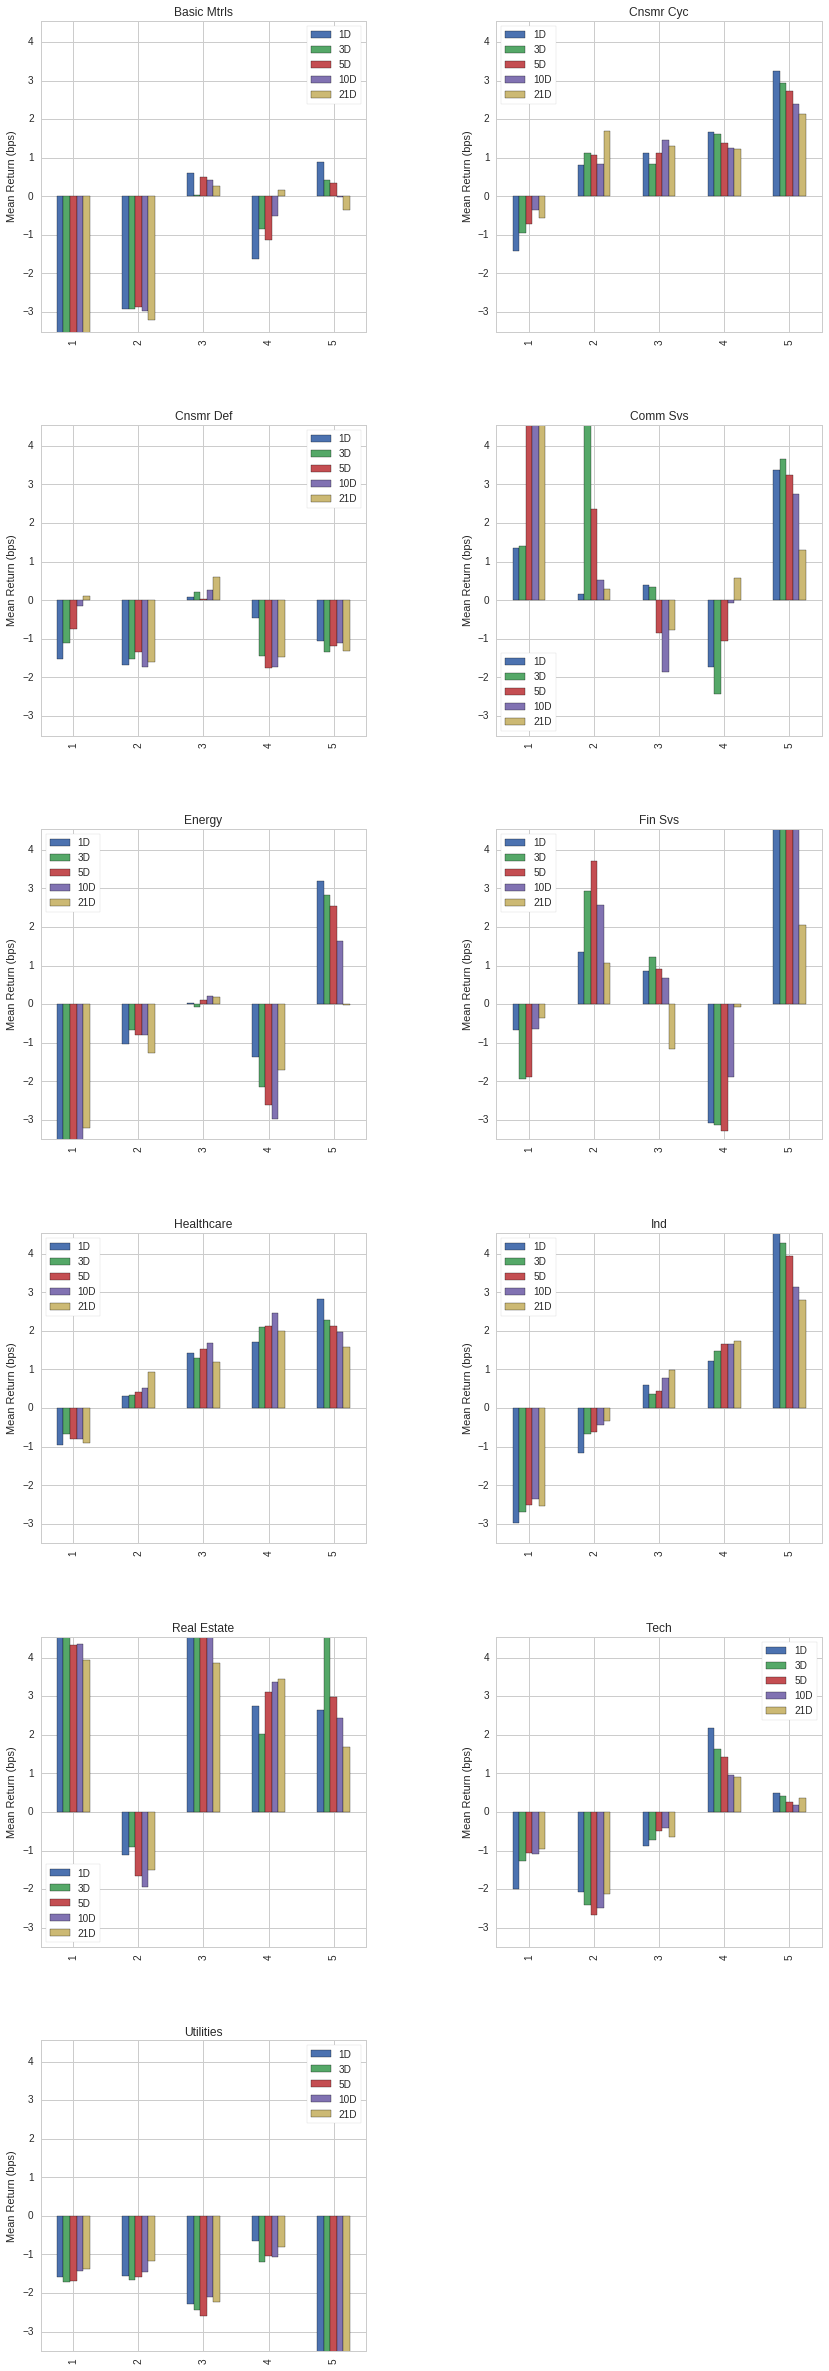

Information Analysis


1D     3D     5D     10D     21D
IC Mean           0.011  0.018  0.021   0.025   0.031
IC Std.           0.076  0.074  0.072   0.065   0.064
Risk-Adjusted IC  0.146  0.244  0.294   0.381   0.484
t-stat(IC)        4.644  7.738  9.333  12.088  15.351
p-value(IC)       0.000  0.000  0.000   0.000   0.000
IC Skew          -0.013  0.036  0.002   0.025   0.103
IC Kurtosis       0.342  0.555  0.725   0.350   0.877

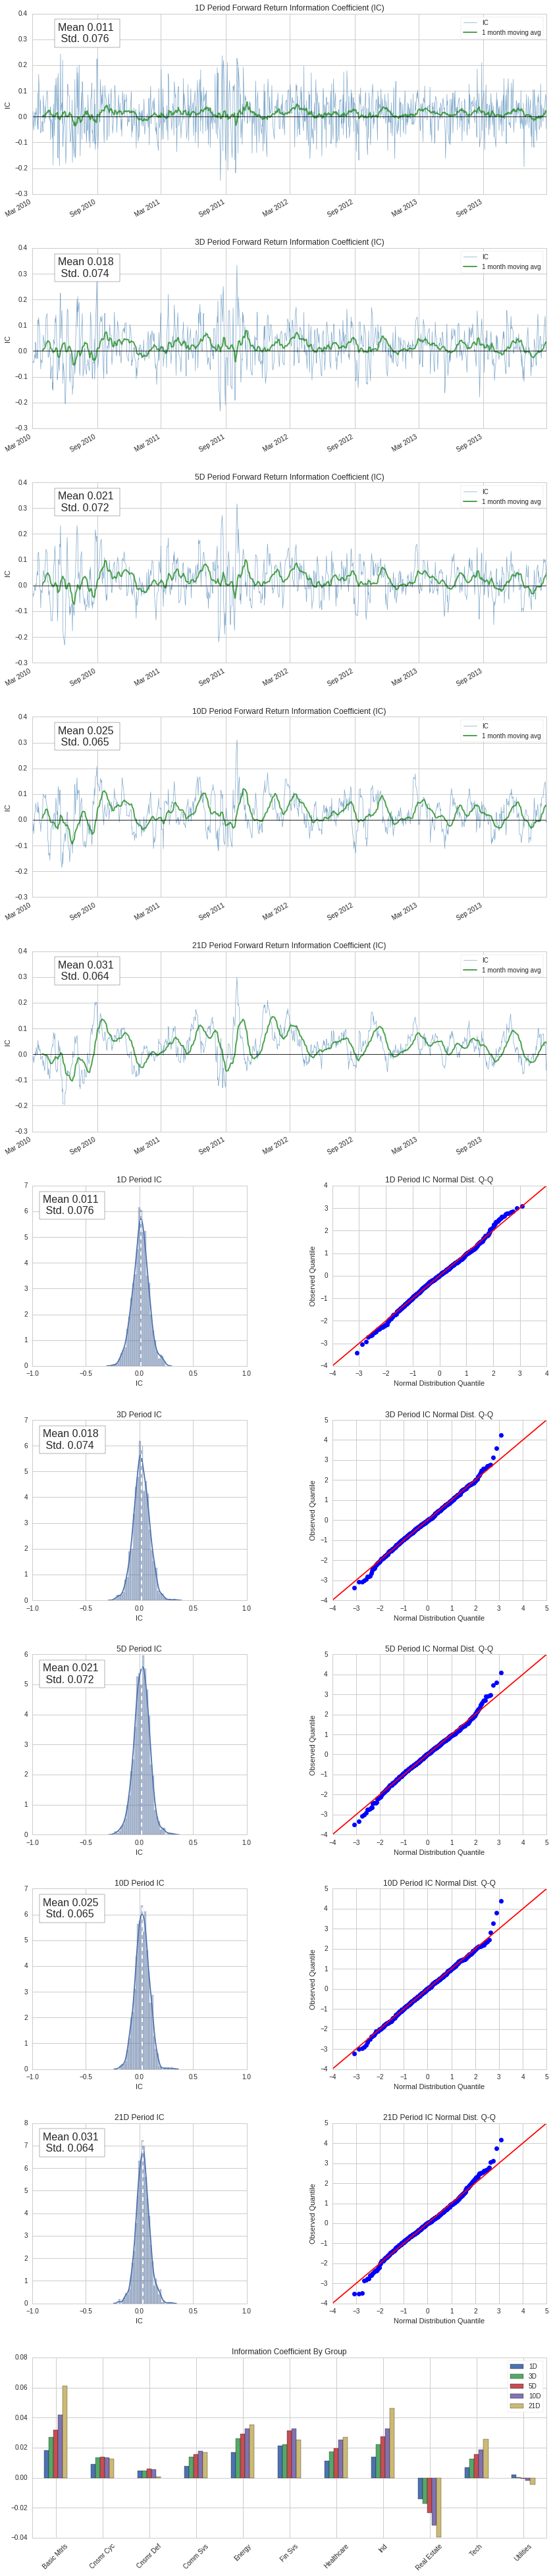

Turnover Analysis


10D     1D    21D     3D     5D
Quantile 1 Mean Turnover   0.250  0.062  0.377  0.123  0.167
Quantile 2 Mean Turnover   0.481  0.141  0.630  0.268  0.350
Quantile 3 Mean Turnover   0.529  0.162  0.665  0.305  0.394
Quantile 4 Mean Turnover   0.483  0.141  0.628  0.269  0.351
Quantile 5 Mean Turnover   0.259  0.063  0.393  0.126  0.172

1D     3D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.986  0.956  0.928  0.859  0.719

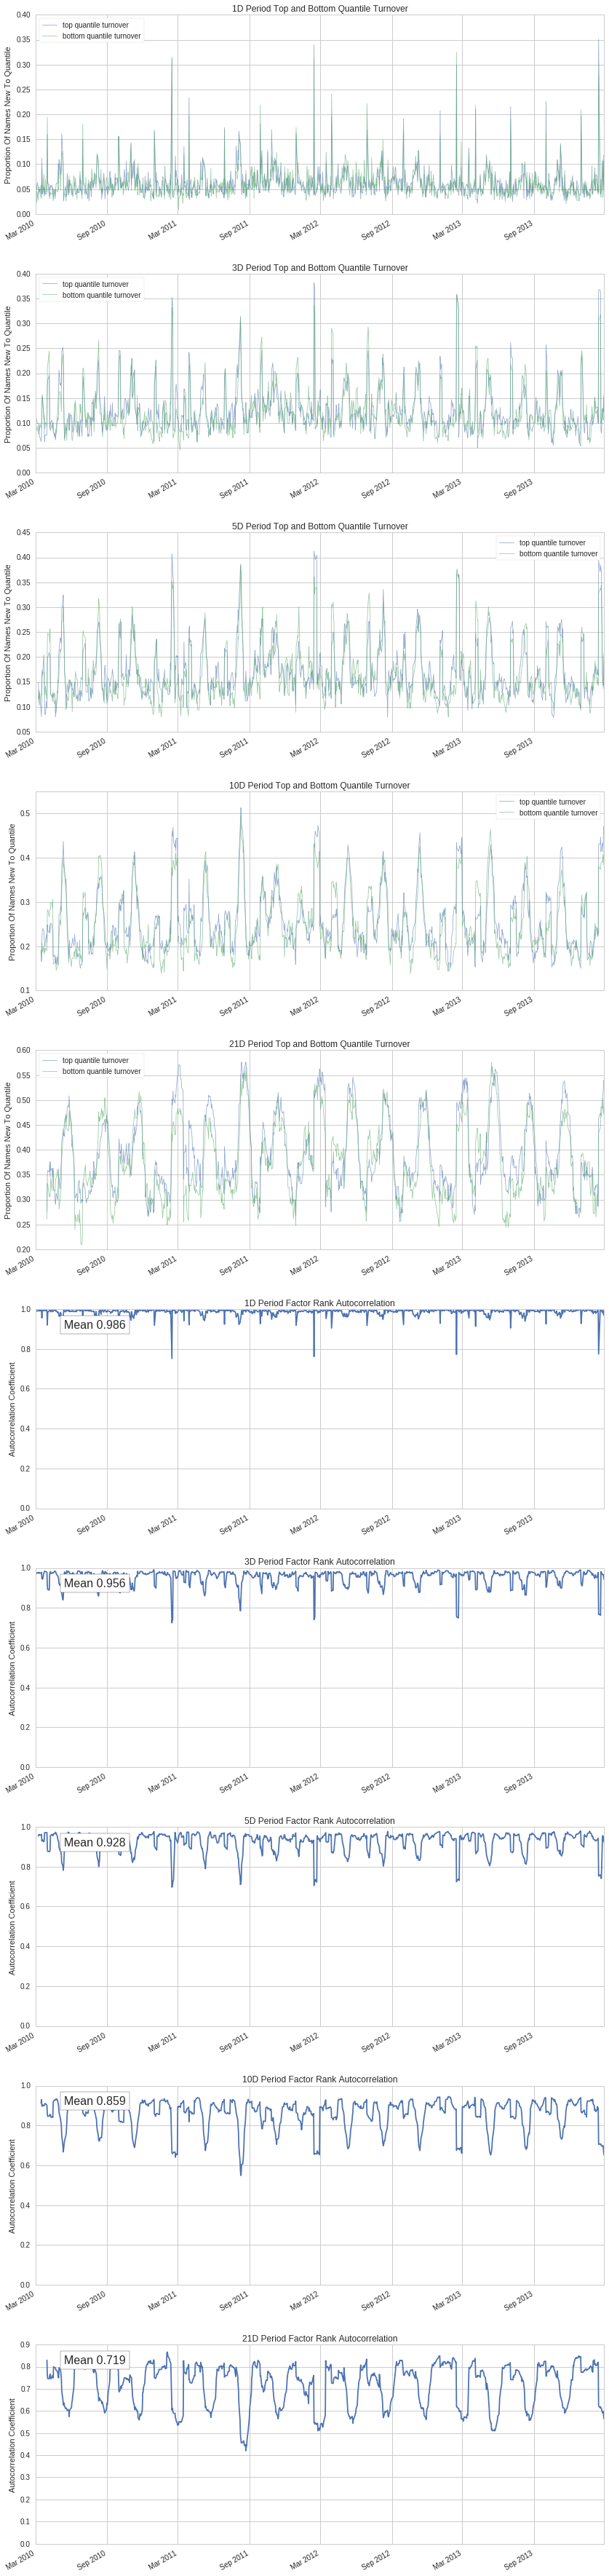

In [80]:
al.tears.create_full_tear_sheet(factor_data, by_group=True);